# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp
import wandb

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from base.dgd.nn import NB_Module
from base.dgd.DGD import DGD
from base.utils.helpers import set_seed, get_activation
from base.model.decoder import Decoder
from base.data.combined import GeneExpressionDatasetCombined
from base.engine.train import train_midgd

from base.plotting.plot_cv2 import plot_latent_space, plot_gene, plot_mirna

In [2]:
from plotnine import ggplot, aes, labs, geom_jitter, geom_smooth, theme_minimal

In [6]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load Data

In [7]:
tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])
tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])

In [8]:
sample_annot = pd.read_table("data/TCGA_sample_anno_iso_match.tsv", sep='\t', index_col=[0])

In [9]:
mirna_annot = pd.read_table("data/TCGA_mirna_anno_iso_match.tsv", sep='\t', index_col=[0])

In [10]:
def data_filtering(df, filter_zero=True, filter_tumor=False):
    if filter_zero:
        zero_counts = (df == 0).mean()
        selected_features = zero_counts[zero_counts < 0.99].index
        df = df[selected_features]
    if filter_tumor:
        df = df[df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal'])]
        
    return df

# Filter data
tcga_mrna = data_filtering(tcga_mrna_raw)
tcga_mirna = data_filtering(tcga_mirna_raw)

# Shuffle the data
tcga_mrna = tcga_mrna.sample(frac=1, random_state=seed)
tcga_mirna = tcga_mirna.sample(frac=1, random_state=seed)

# color mapping
color_mapping = dict(zip(tcga_mrna['cancer_type'], tcga_mrna['color']))

# make data split for train, validation, and test sets
train_ratio= 0.7

train_mrna, val_mrna = train_test_split(tcga_mrna, train_size=train_ratio, stratify=tcga_mrna['cancer_type'], random_state=seed) 
val_mrna, test_mrna = train_test_split(val_mrna, test_size=0.50, stratify=val_mrna['cancer_type'], random_state=seed)

# Get the indices of the samples in each split
train_idx = train_mrna.index
val_idx = val_mrna.index
test_idx = test_mrna.index

# Use the same indices to split tcga_mirna
train_mirna = tcga_mirna.loc[train_idx]
val_mirna = tcga_mirna.loc[val_idx]
test_mirna = tcga_mirna.loc[test_idx]

# Train, val, and test data loaders
batch_size = 128

# Default scaling_type = "mean"
train_dataset = GeneExpressionDatasetCombined(train_mrna, train_mirna, scaling_type='mean')
validation_dataset = GeneExpressionDatasetCombined(val_mrna, val_mirna, scaling_type='mean')
test_dataset = GeneExpressionDatasetCombined(test_mrna, test_mirna, scaling_type='mean')

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False,
                                                num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_workers)
data_loader = train_loader, validation_loader, test_loader


In [11]:
print(tcga_mrna.shape)
print(tcga_mirna.shape)

(10676, 19745)
(10676, 2028)


In [12]:
# Change column name
mirna_column = pd.Series(train_mirna.columns[:-4])

# Convert mirna_annot DataFrame to a dictionary for mapping
mapping_dict = dict(zip(mirna_annot['mature_iso_id'], mirna_annot['mature_iso_name_miRBase']))

# Replace the values in mirna_column using the mapping dictionary
mirna_column = mirna_column.map(mapping_dict).fillna(mirna_column)
mirna_column = np.array(mirna_column)

In [13]:
mirna_column

array(['hsa-let-7a-5p', 'hsa-let-7a-2-3p', 'hsa-let-7b-5p', ...,
       'hsa-miR-3168', 'hsa-miR-3119', 'hsa-miR-6823-3p'], dtype=object)

In [14]:
palette = dict(zip(train_mirna['cancer_type'], train_mirna['color']))

# Load Model

In [15]:
# dgd = torch.load('results/final_dgd_midgd.pickle', map_location=torch.device('cpu'))

In [16]:
# new_rep = learn_new_representation(dgd, test_loader, learning_rates=1e-2, weight_decay=0., test_epochs=50)
# dgd.test_rep = new_rep

In [17]:
# torch.save(dgd, 'models/midgd_final.pt')

In [18]:
# dgd = torch.load('models/midgd_final.pt', map_location=torch.device('cpu'))
dgd = torch.load('models/05082024_midgd.pth', map_location=torch.device('cpu'))
# dgd = torch.load('models/midgd_final.pt')
# dgd.load_state_dict(torch.load('sweep/midgd_t5z3p69x.pt', map_location=torch.device('cpu')))

In [19]:
def plot_latent_space(rep, means, samples, gmm, labels, color_mapping, dataset="Train", 
                      savedir="plots", filename=None):
    # get PCA
    pca = PCA(n_components=2)
    pca.fit(means)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)
    df = pd.DataFrame(rep_pca, columns=["PC1", "PC2"])
    df["type"] = "Representation"
    df["label"] = labels
    df_temp = pd.DataFrame(samples_pca, columns=["PC1", "PC2"])
    df_temp["type"] = "GMM samples"
    df = pd.concat([df,df_temp])
    df_temp = pd.DataFrame(means_pca, columns=["PC1", "PC2"])
    df_temp["type"] = "GMM means"
    df = pd.concat([df,df_temp])

    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    # add spacing between subplots
    fig.subplots_adjust(wspace=0.2, top=0.9)

    # first plot: representations, means and samples
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="type", size="type", sizes=[5,3,12], alpha=0.8, ax=ax[0], palette=["steelblue","orange","black"])
    ax[0].set_title(str(dataset)+" Latent Space (by type)")
    ax[0].legend(loc='upper right', fontsize='small')
    
    # add explained variance to x-label and y-label for first plot
    ax[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")

    # second plot: representations by label
    sns.scatterplot(data=df[df["type"] == "Representation"], x="PC1", y="PC2", hue="label", s=6, alpha=0.8, ax=ax[1], palette=color_mapping)
    ax[1].set_title(str(dataset)+" Latent Space (by label)")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3)
    
    # add explained variance to x-label and y-label for second plot
    ax[1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax[1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")


    # plot
    plt.suptitle(f'PCA of {dataset} Latent Space', fontsize=16)
    plt.tight_layout()
    
    if filename:
        plt.savefig(os.path.join(savedir, filename))
    plt.show()

In [20]:
plot_latent_space(*dgd.get_latent_space_values("test",3000), dgd.gmm, test_loader.dataset.label, color_mapping, dataset="Test",
                 filename="PCA of test latent space.pdf")

AttributeError: 'NoneType' object has no attribute 'z'

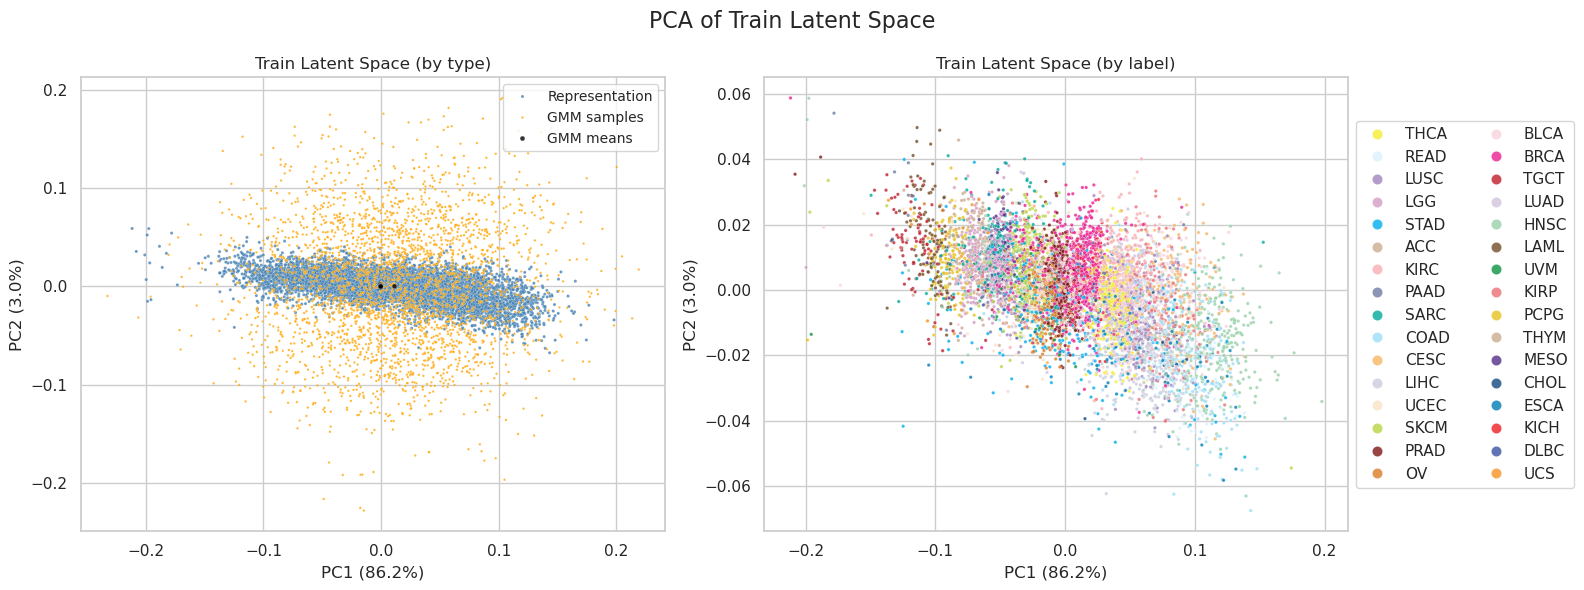

In [21]:
plot_latent_space(*dgd.get_latent_space_values("train",3000), dgd.gmm, train_loader.dataset.label, color_mapping, dataset="Train",
                 filename="PCA of train latent space.pdf")

In [ ]:
dgd

# Load and learn sparse data representation

In [27]:
from base.engine.predict import learn_new_representation

In [28]:
mnt_path = '/home/farzamani/'
project_path = os.path.join(mnt_path, "jsp_student_projects/miRNA_DGD_Farhad_F2024/")
data_path = os.path.join(project_path, "miDGD/data/downsampled/")

In [29]:
sparsity = ["1000", "5000", "10000", "50000", "1e+05", "5e+05", "1e+06", "5e+06", "1e+07"]

mrna_sparse = []
sparse_mrna_test = []

for i, sp in enumerate(sparsity):
    datapath = os.path.join(data_path, f"TCGA_mrna_downsampled_{sp}.tsv")
    print(datapath)
    mrna = pd.read_csv(datapath, sep="\t", index_col=[0])
    mrna_sparse.append(mrna)
    
    mrna_sparse[i] = mrna_sparse[i].reindex(index=tcga_mrna.index, columns=tcga_mrna.columns)
    sparse_mrna_test.append(mrna_sparse[i].loc[test_idx])

print("Done!")

/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled/TCGA_mrna_downsampled_1000.tsv
/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled/TCGA_mrna_downsampled_5000.tsv
/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled/TCGA_mrna_downsampled_10000.tsv
/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled/TCGA_mrna_downsampled_50000.tsv
/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled/TCGA_mrna_downsampled_1e+05.tsv
/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled/TCGA_mrna_downsampled_5e+05.tsv
/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled/TCGA_mrna_downsampled_1e+06.tsv
/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled/TCGA_mrna_downsampled_5e+06.tsv
/home/farzamani/jsp_student_projects/miRNA_DGD_Farhad_F2024/miDGD/data/downsampled

In [30]:
sparsity = ["1000", "5000", "10000", "50000", "1e+05", "5e+05", "1e+06", "5e+06", "1e+07"]

test_datasets = []
test_loaders = []
# test_rep_sparse = []
batch_size = 128

for i, sp in enumerate(sparsity):
    # Train, val, and test data loaders
    dataset = GeneExpressionDatasetCombined(sparse_mrna_test[i], test_mirna, scaling_type='mean')
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size, 
                                         shuffle=False,
                                         num_workers=num_workers)
    test_datasets.append(dataset)
    test_loaders.append(loader)

#     test_rep = learn_new_representation(dgd, loader, learning_rates=1e-2, weight_decay=1e-4, test_epochs=20)
#     test_rep_sparse.append(test_rep)

# torch.save(test_rep_sparse, "results/test_rep.pt")
print("Done!")

Done!


In [31]:
test_rep_load = torch.load("results/test_rep.pt")

In [243]:
def plot_latent_space_sparsity(test_rep_load, means, gmm, sparsity, test_loaders, color_mapping, index, dataset="Train", 
                      savedir="plots", filename=None):
    # get PCA
    df_combined = []

    pca = PCA(n_components=2)
    pca.fit(means)
    
    means_pca = pca.transform(means)
    df_gmm = pd.DataFrame(means_pca, columns=["PC1", "PC2"])
    df_gmm['index'] = np.arange(0,32)
    df_gmm["type"] = "GMM means"
    
    for i, sp in enumerate(sparsity):
        rep = test_rep_load[i].z.clone().detach().cpu().numpy()
        rep_pca = pca.transform(rep)
        df = pd.DataFrame(rep_pca, columns=["PC1", "PC2"])
        df["type"] = "Representation"
        df["label"] = test_loaders[i].dataset.label
        df["data"] = f"{sp}"
        
        df_combined.append(df)
    
    df = pd.concat(df_combined).reset_index()

    # Find index cluster
    for i, sp in enumerate(sparsity):
        rep = test_rep_load[i]
        gmm_cluster = dgd.gmm.clustering(rep(index)).detach().cpu().numpy()
        break

    # Create plotting data
    df_gmm = df_gmm[df_gmm['index'] == gmm_cluster]
    df_gmm['data'] = 'GMM Means'
    df_plot = pd.concat([df[df['index'] == index], df_gmm]).reset_index()
    label = df_plot['label'].iloc[0]
    
    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    # add spacing between subplots
    fig.subplots_adjust(wspace=0.2, top=0.9)    

    # Make Plot
    sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="type", size="data", sizes=(90, 10), alpha=0.8, ax=ax, palette=["steelblue","orange"])
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize='small')
    
    # add explained variance to x-label and y-label for first plot
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")

    # plot
    plt.title(f'PCA of {dataset} Latent Space (one {label} sample)', fontsize=16)
    plt.tight_layout()
    
    if filename:
        plt.savefig(os.path.join(savedir, filename))
    plt.show()
    return df_plot

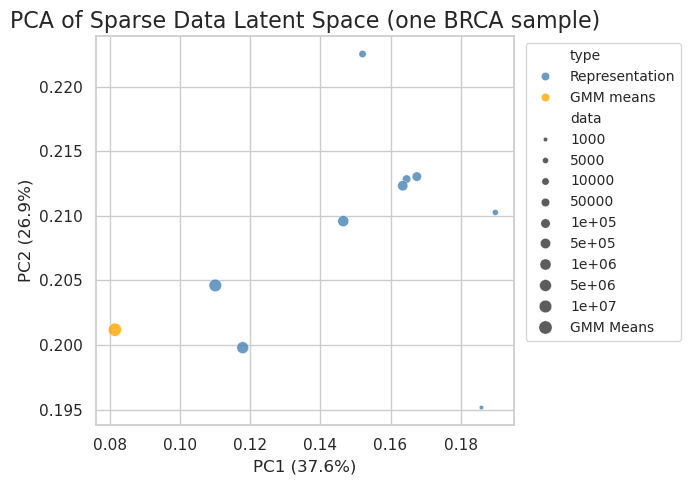

level_0  index       PC1       PC2            type label       data
0       50     50  0.185916  0.195167  Representation  BRCA       1000
1     1652     50  0.189899  0.210262  Representation  BRCA       5000
2     3254     50  0.152027  0.222517  Representation  BRCA      10000
3     4856     50  0.164582  0.212841  Representation  BRCA      50000
4     6458     50  0.167507  0.213033  Representation  BRCA      1e+05
5     8060     50  0.163491  0.212328  Representation  BRCA      5e+05
6     9662     50  0.146534  0.209590  Representation  BRCA      1e+06
7    11264     50  0.117861  0.199801  Representation  BRCA      5e+06
8    12866     50  0.110041  0.204616  Representation  BRCA      1e+07
9       18     18  0.081410  0.201191       GMM means   NaN  GMM Means

In [314]:
sparsity = ["1000", "5000", "10000", "50000", "1e+05", "5e+05", "1e+06", "5e+06", "1e+07"]

plot_latent_space_sparsity(test_rep_load=test_rep_load, 
                           means=dgd.gmm.mean.clone().detach().cpu().numpy(), 
                           gmm=dgd.gmm,
                           sparsity=sparsity,
                           test_loaders=test_loaders, 
                           color_mapping=color_mapping,
                           index=50,
                           dataset=f"Sparse Data",
                           filename=f"PCA of sparse data latent space.pdf")

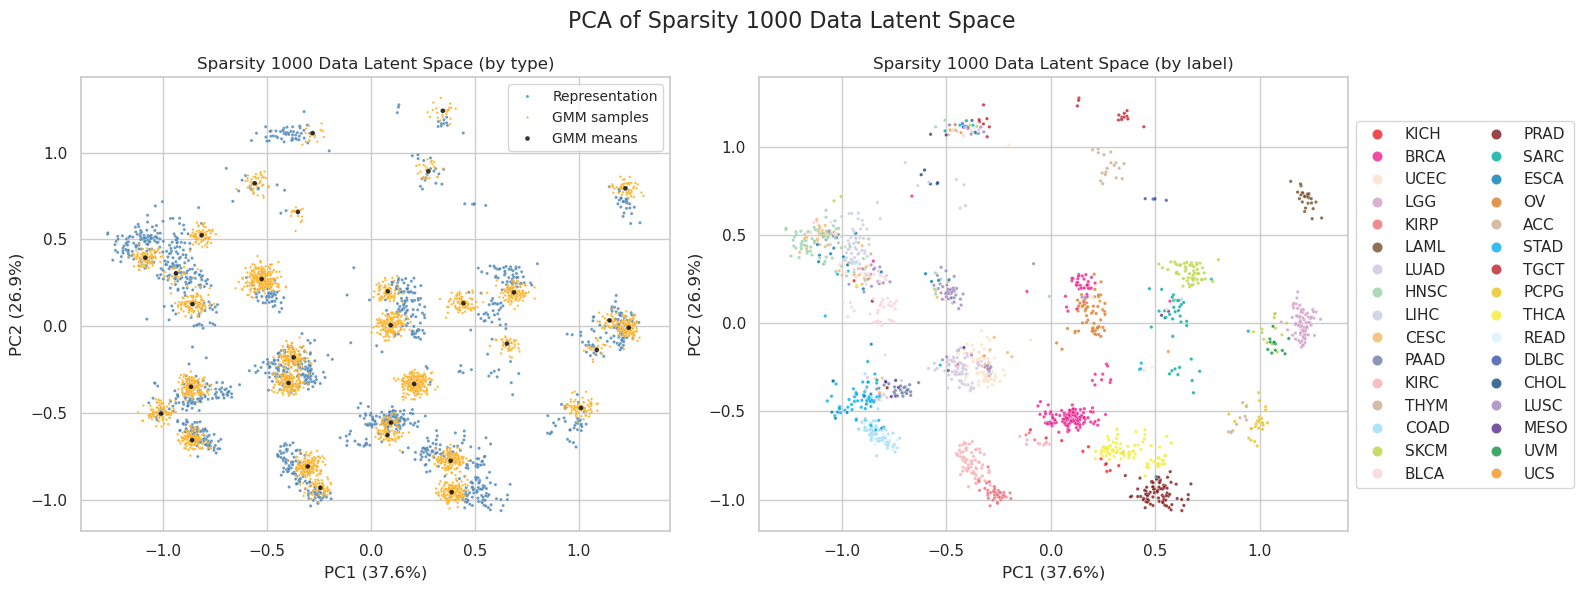

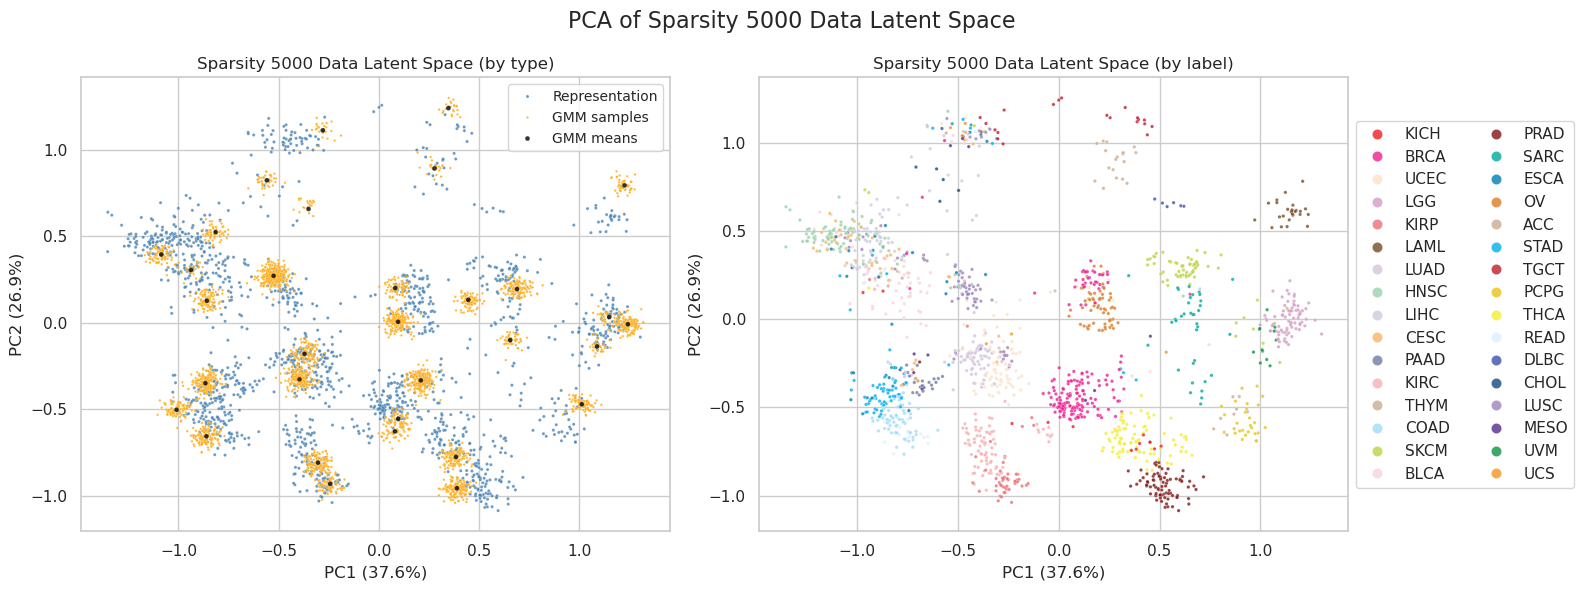

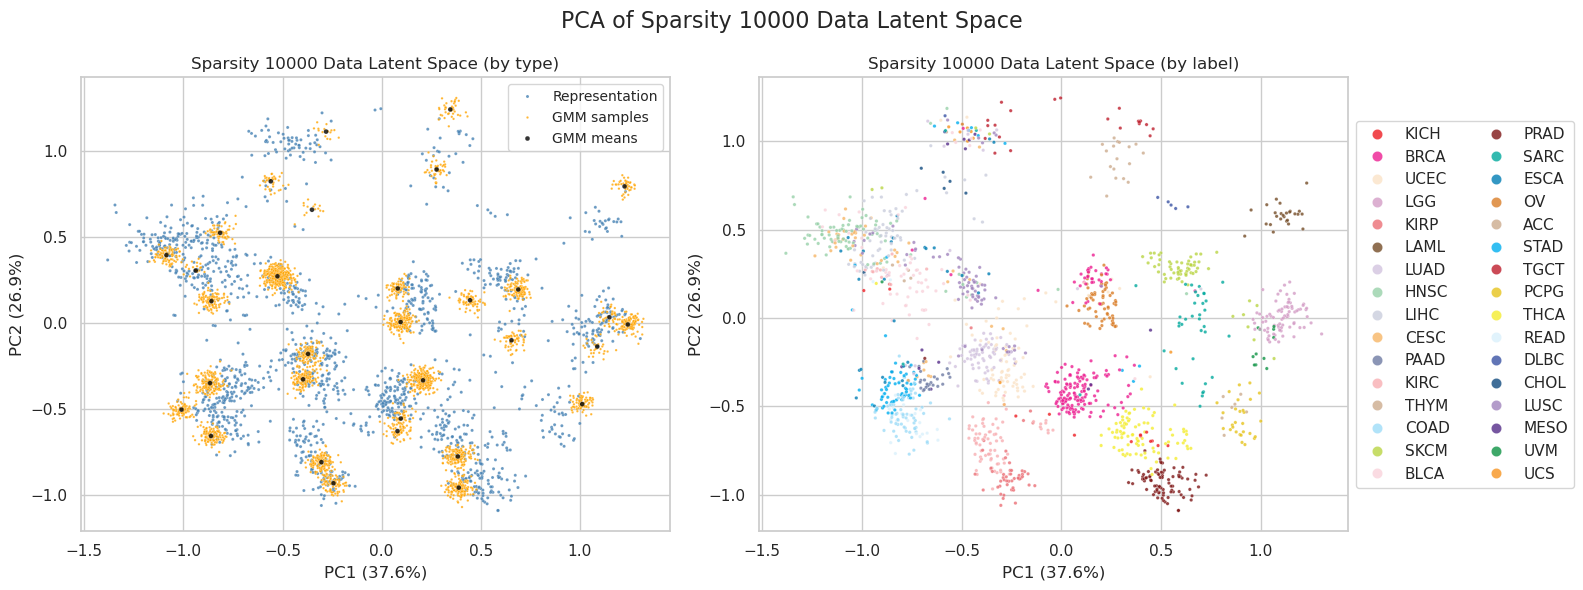

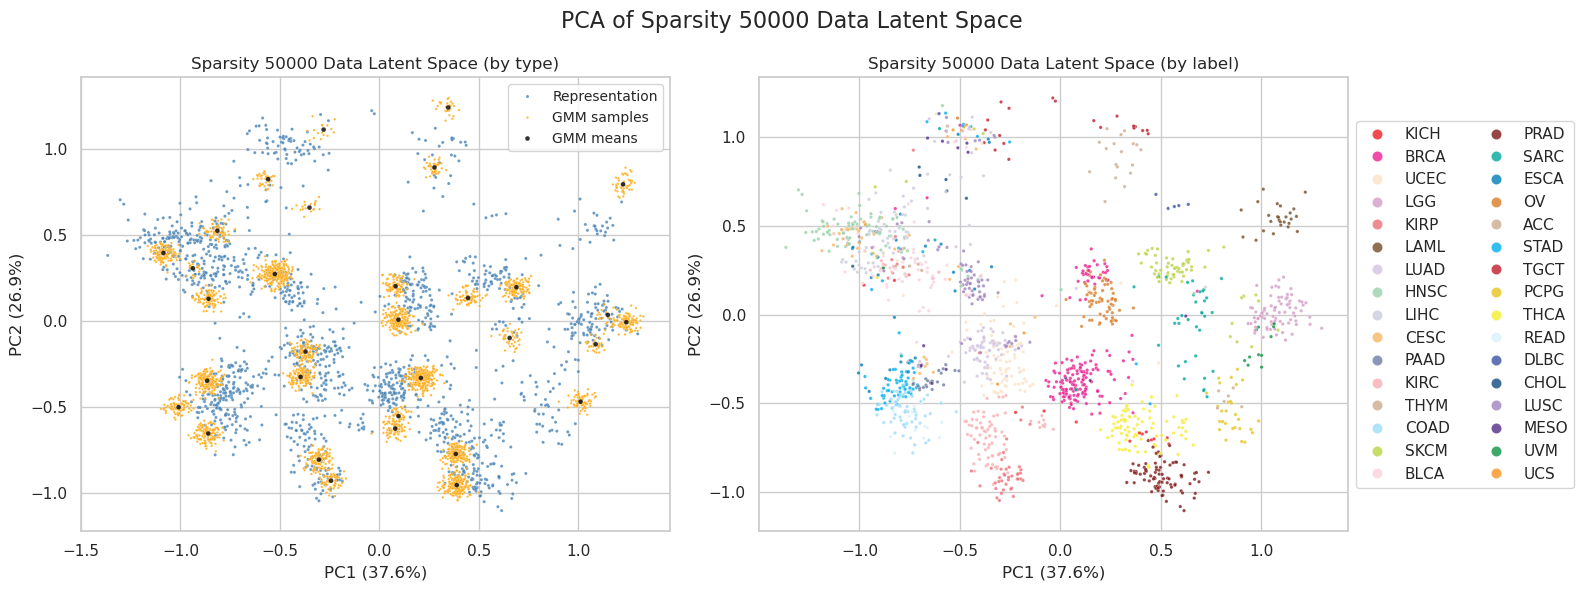

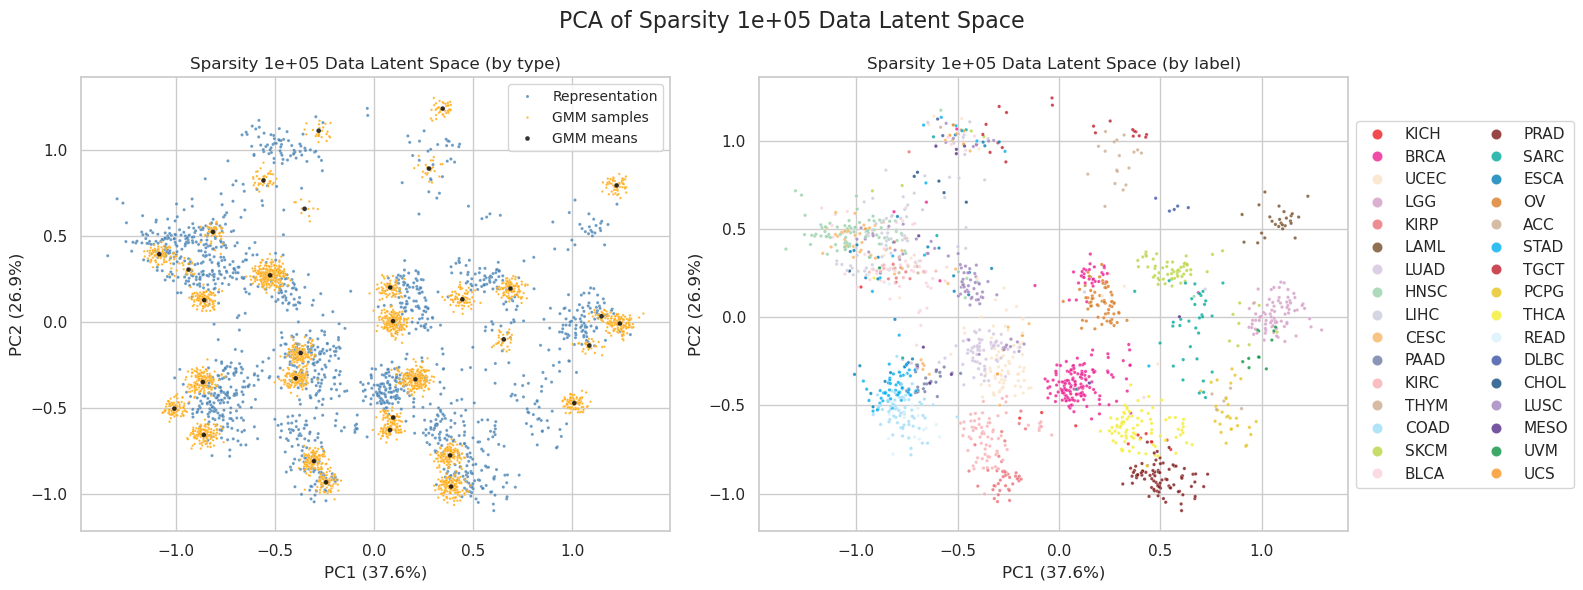

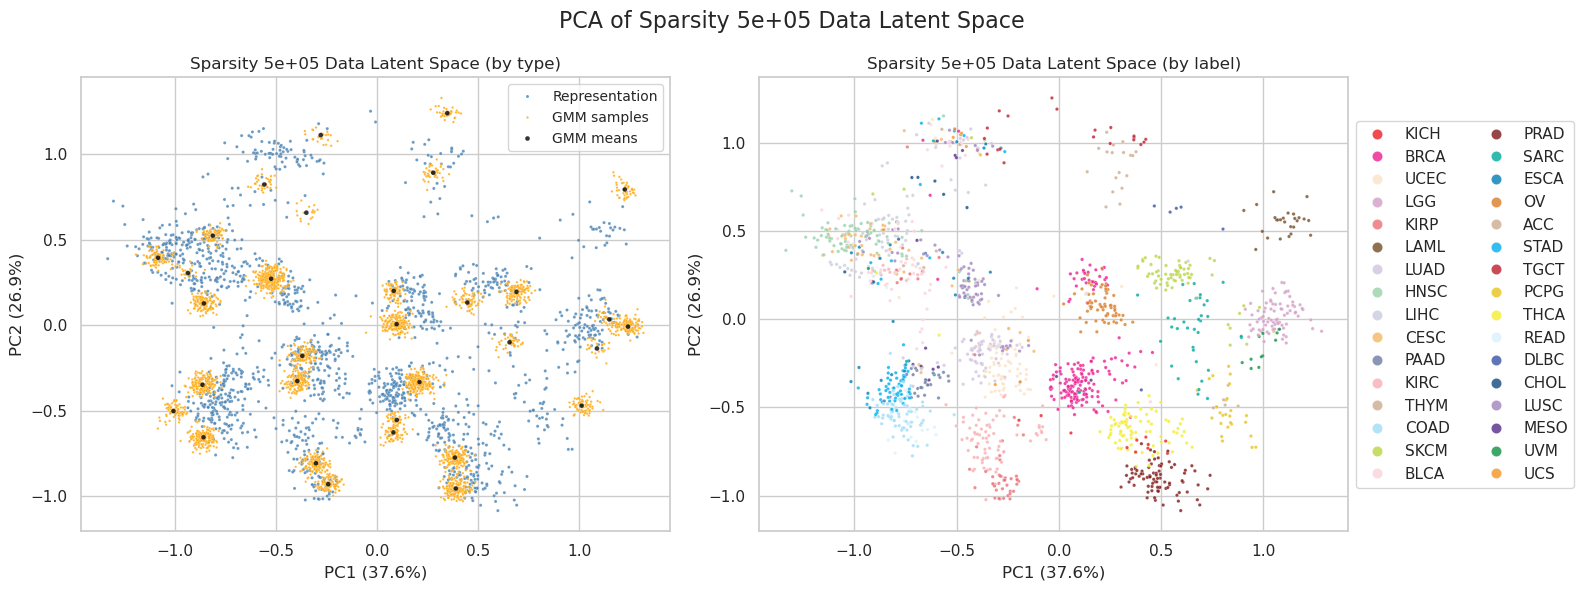

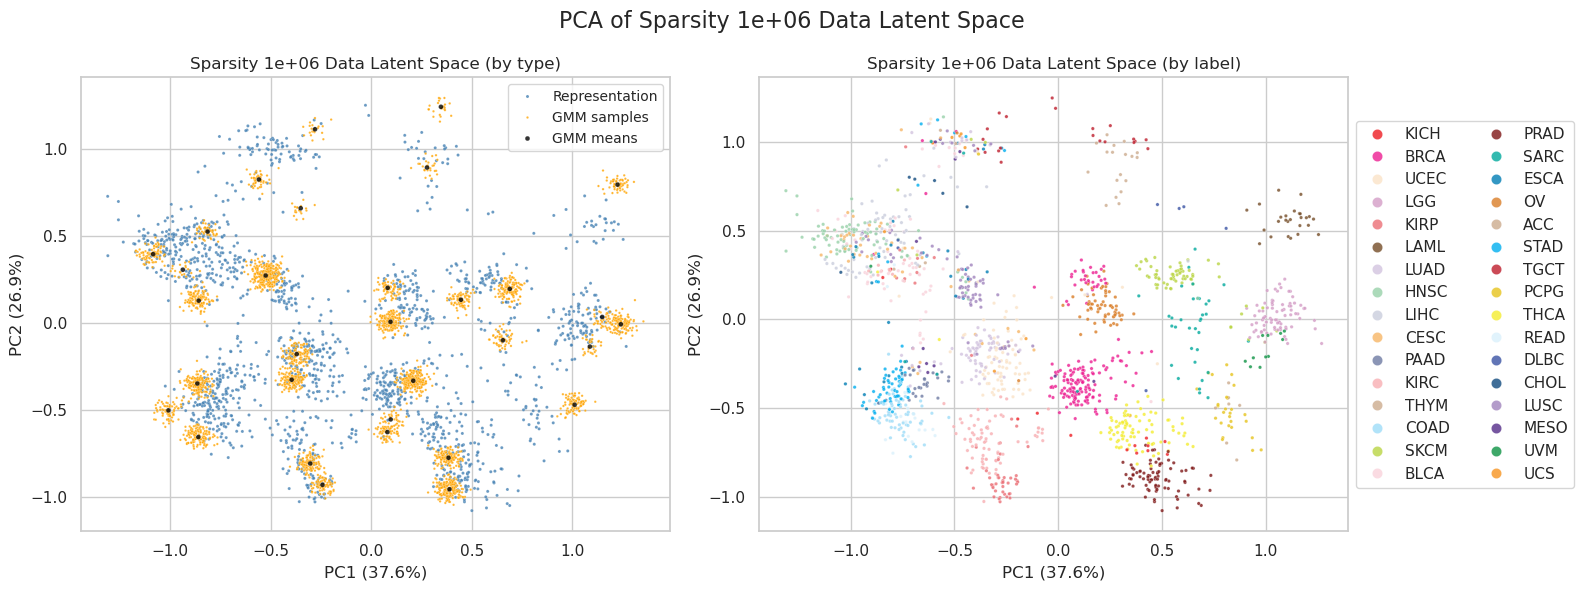

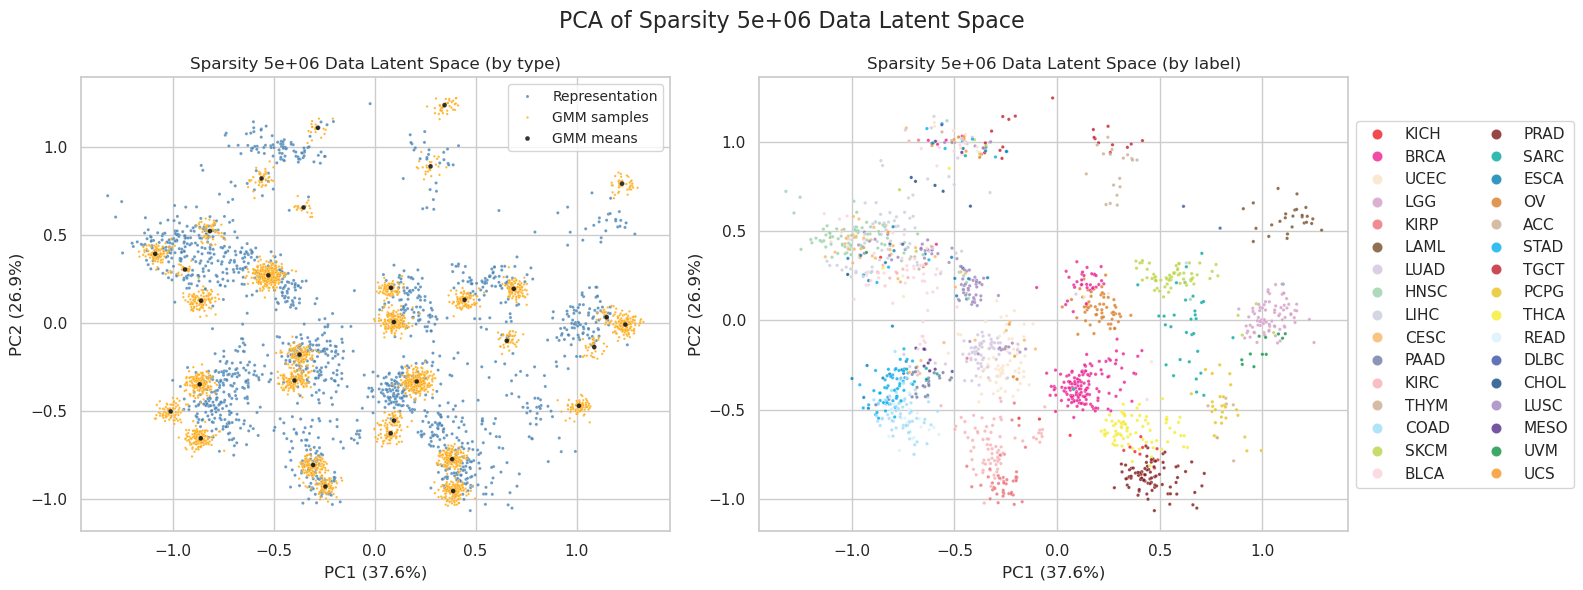

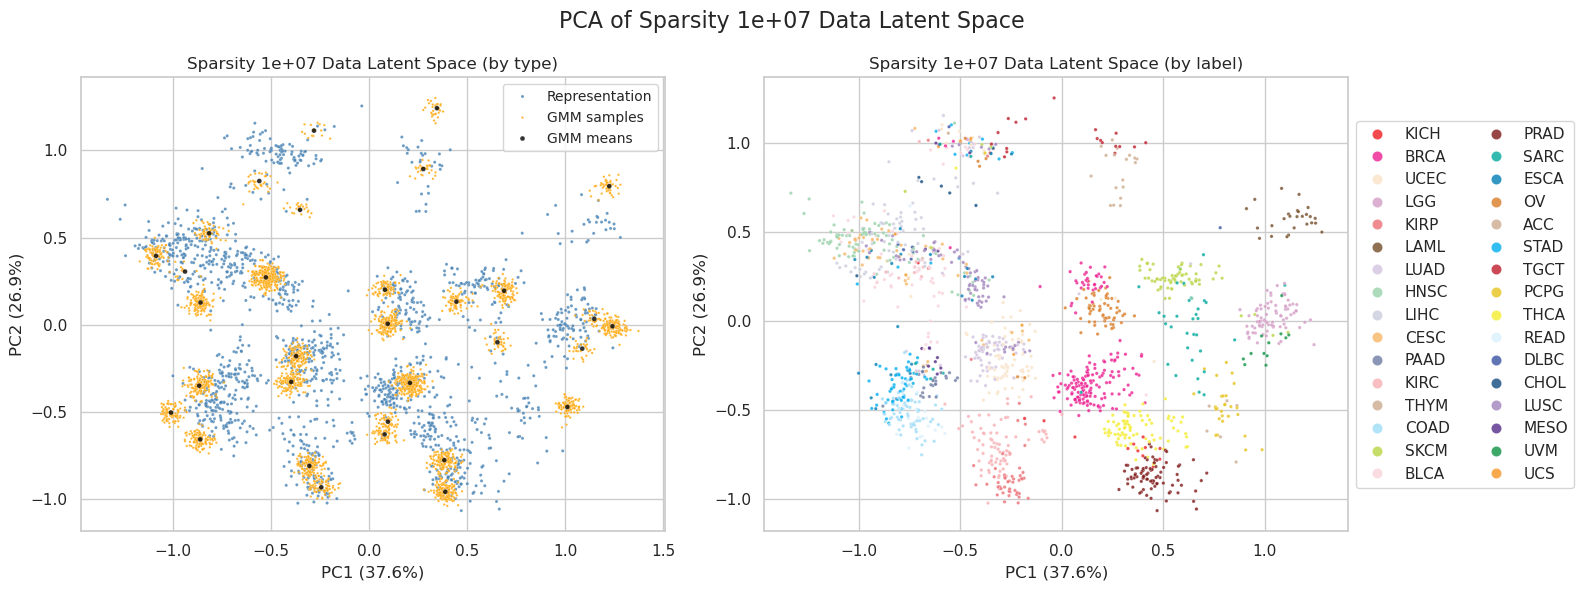

In [259]:
sparsity = ["1000", "5000", "10000", "50000", "1e+05", "5e+05", "1e+06", "5e+06", "1e+07"]

for i, sp in enumerate(sparsity):
    plot_latent_space(test_rep_load[i].z.clone().detach().cpu().numpy(), 
                      dgd.gmm.mean.clone().detach().cpu().numpy(), 
                      dgd.gmm.sample(3000).detach().cpu().numpy(), 
                      dgd.gmm, 
                      test_loaders[i].dataset.label, color_mapping, dataset=f"Sparsity {sp} Data",
                      filename=f"PCA of test latent space with sparsity {sp}.pdf")

# Generate Analysis Data

In [265]:
def _add_columns(X, y, data_loader):
    X = X.assign(tissue=data_loader.dataset.tissue_type)
    X = X.assign(sample=data_loader.dataset.sample_type)
    X = X.assign(color=data_loader.dataset.color)
    X = X.assign(cancer_type=data_loader.dataset.label)
    
    y = y.assign(tissue=data_loader.dataset.tissue_type)
    y = y.assign(sample=data_loader.dataset.sample_type)
    y = y.assign(color=data_loader.dataset.color)
    y = y.assign(cancer_type=data_loader.dataset.label)
    return X, y

def _get_data_prediction(dgd, data_loader, mirna_column_name, dataset="train"):
    with torch.inference_mode():
        scaling = torch.mean(data_loader.dataset.mirna_data, axis=1)
        if dataset == "train":
            X, _ = dgd.forward(dgd.train_rep()) 
        elif dataset == "val":
            X, _ = dgd.forward(dgd.val_rep()) 
        elif dataset == "test":
            X, _ = dgd.forward(dgd.test_rep()) 
        X = X * scaling.unsqueeze(1).to(device)
        X = X.detach().cpu().numpy()
        X = pd.DataFrame(X, columns=mirna_column_name)

        y = data_loader.dataset.mirna_data
        y = y.detach().cpu().numpy()
        y = pd.DataFrame(y, columns=mirna_column_name)
        
        X, y = _add_columns(X, y, data_loader)
    return X, y

def _get_data_pred_from_rep(dgd, test_rep, data_loader, mirna_column_name):
    with torch.inference_mode():
        scaling = torch.mean(data_loader.dataset.mirna_data, axis=1)
        X, _ = dgd.forward(test_rep.z) 
        X = X * scaling.unsqueeze(1).to(device)
        X = X.detach().cpu().numpy()
        X = pd.DataFrame(X, columns=mirna_column_name)

        y = data_loader.dataset.mirna_data
        y = y.detach().cpu().numpy()
        y = pd.DataFrame(y, columns=mirna_column_name)
        
        X, y = _add_columns(X, y, data_loader)
    return X, y
    
def generate_analysis_data(dgd, train_loader, validation_loader, test_loader, mirna_column_name, subset=False, dataset="test"):
    if subset:
        if dataset == "train":
            X_train, y_train = _get_data_prediction(dgd, train_loader, mirna_column_name, dataset="train")
            train = pd.DataFrame(
                data={
                    'X': X_train[subset], 
                    'y': y_train[subset],
                    'cancer_type': train_loader.dataset.label,
                    'tissue': train_loader.dataset.tissue_type,
                    'color': train_loader.dataset.color
                }
            )
            return train
        elif dataset == "val":
            X_val, y_val = _get_data_prediction(dgd, validation_loader, mirna_column_name, dataset="val")
            val = pd.DataFrame(
                data={
                    'X': X_val[subset], 
                    'y': y_val[subset],
                    'cancer_type': validation_loader.dataset.label,
                    'tissue': validation_loader.dataset.tissue_type,
                    'color': validation_loader.dataset.color
                }
            )
            return val
        elif dataset == "test":
            X_test, y_test = _get_data_prediction(dgd, test_loader, mirna_column_name, dataset="test")
            test = pd.DataFrame(
                data={
                    'X': X_test[subset], 
                    'y': y_test[subset],
                    'cancer_type': test_loader.dataset.label,
                    'tissue': test_loader.dataset.tissue_type,
                    'color': test_loader.dataset.color
                }
            )
            return test
    else:
        X_train, y_train = _get_data_prediction(dgd, train_loader, mirna_column_name, dataset="train")
        X_val, y_val = _get_data_prediction(dgd, validation_loader, mirna_column_name, dataset="val")
        X_test, y_test = _get_data_prediction(dgd, test_loader, mirna_column_name, dataset="test")
        
    return X_train, y_train, X_val, y_val, X_test, y_test

def get_mirna_data(dgd, data_loader, subset, mirna_column_name=mirna_column, dataset="test"):
    return generate_analysis_data(dgd, *data_loader, mirna_column_name, subset=subset, dataset=dataset)

X_train, y_train, X_val, y_val, X_test, y_test = generate_analysis_data(dgd, train_loader, validation_loader, test_loader, mirna_column)

In [266]:
save = False
if save:
    X_train.to_csv("results/data/xtrain.csv")
    y_train.to_csv("results/data/ytrain.csv")
    X_val.to_csv("results/data/xval.csv")
    y_val.to_csv("results/data/yval.csv")
    X_test.to_csv("results/data/xtest.csv")
    y_test.to_csv("results/data/ytest.csv")

# Exploratory

In [267]:
X_val['tissue'].value_counts()

tissue
Tumor     1507
Normal      94
Name: count, dtype: int64

In [275]:
tissue_mapping = dict(zip(sample_annot['cancer_type'], sample_annot['primary_site']))
tissue_mapping

{'BRCA': 'Breast',
 'LUAD': 'Lung',
 'STAD': 'Stomach',
 'COAD': 'Colorectal',
 'DLBC': 'Lymph Nodes',
 'CHOL': 'Bile Duct',
 'LIHC': 'Liver',
 'PRAD': 'Prostate',
 'KICH': 'Kidney',
 'LAML': 'Bone Marrow',
 'PCPG': 'Adrenal Gland',
 'THYM': 'Thymus',
 'SKCM': 'Skin',
 'SARC': 'Soft Tissue',
 'ACC': 'Adrenal Gland',
 'HNSC': 'Head and Neck',
 'TGCT': 'Testis',
 'PAAD': 'Pancreas',
 'KIRP': 'Kidney',
 'KIRC': 'Kidney',
 'MESO': 'Pleura',
 'THCA': 'Thyroid',
 'LGG': 'Brain',
 'ESCA': 'Esophagus',
 'READ': 'Colorectal',
 'BLCA': 'Bladder',
 'LUSC': 'Lung',
 'UVM': 'Eye',
 'UCS': 'Uterus',
 'UCEC': 'Uterus',
 'CESC': 'Cervix',
 'OV': 'Ovary'}

# Test Latent Space

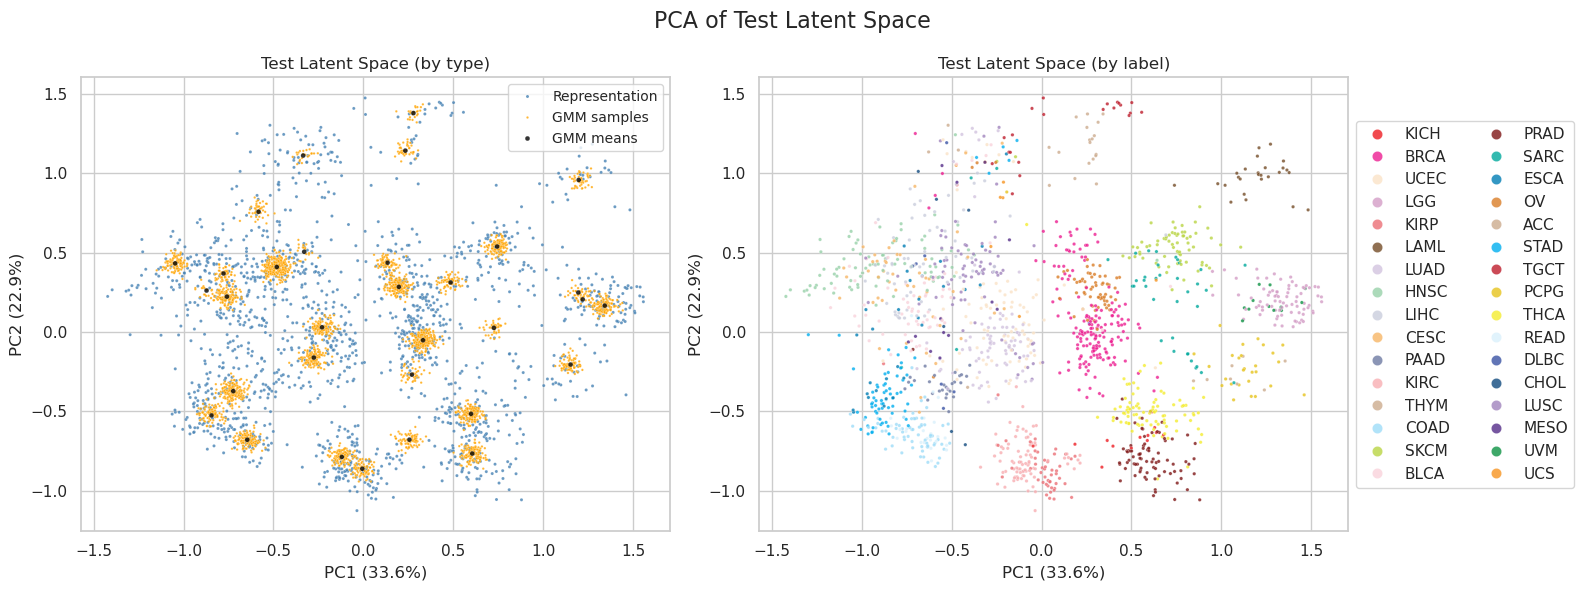

In [198]:
plot_latent_space(*dgd.get_latent_space_values("test",3000), dgd.gmm, test_loader.dataset.label, color_mapping, dataset="Test",
                 filename="PCA of test latent space.pdf")

In [98]:
def plot_latent_component(dgd, dgd_rep, data_loader, dataset="Test"):
# get PCA

    rep = dgd_rep.z.detach().numpy()
    labels = data_loader.dataset.label
    clustering = []
    
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)
    df = pd.DataFrame(rep_pca, columns=["PC1", "PC2"])
    df["label"] = labels
    
    rep = dgd_rep
    for i in range(len(rep.z)):
        cluster = dgd.gmm.clustering(rep(i)).unsqueeze(0).detach().cpu().numpy()
        clustering.extend(cluster)
    df["cluster"] = clustering
    df["cluster"] = df["cluster"].astype('category')
    
    label_counts = df.groupby(['cluster', 'label'], observed=False).size().reset_index(name='counts')
    most_frequent_labels = label_counts.loc[label_counts.groupby('cluster', observed=False)['counts'].idxmax()]
    cluster_to_label = dict(zip(most_frequent_labels['cluster'], most_frequent_labels['label']))
    df['cluster_name'] = df['cluster'].map(cluster_to_label)
    
    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    # add spacing between subplots
    fig.subplots_adjust(wspace=0.2, top=0.9)
    
    # first plot: representations, means and samples
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="cluster_name", s=7, alpha=0.8, ax=ax[0], palette=color_mapping)
    ax[0].set_title(str(dataset)+" Latent Space (by GMM Component)")
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3)
    
    
    # add explained variance to x-label and y-label for first plot
    ax[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    
    # second plot: representations by label
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="label", s=7, alpha=0.8, ax=ax[1], palette=color_mapping)
    ax[1].set_title(str(dataset)+" Latent Space (by Cancer Type)")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3)
    
    # add explained variance to x-label and y-label for second plot
    ax[1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax[1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    
    # plot
    plt.suptitle(f'PCA of {dataset} Latent Space Cluster (GMM Component)', fontsize=16)
    plt.tight_layout()
    
    plt.show()

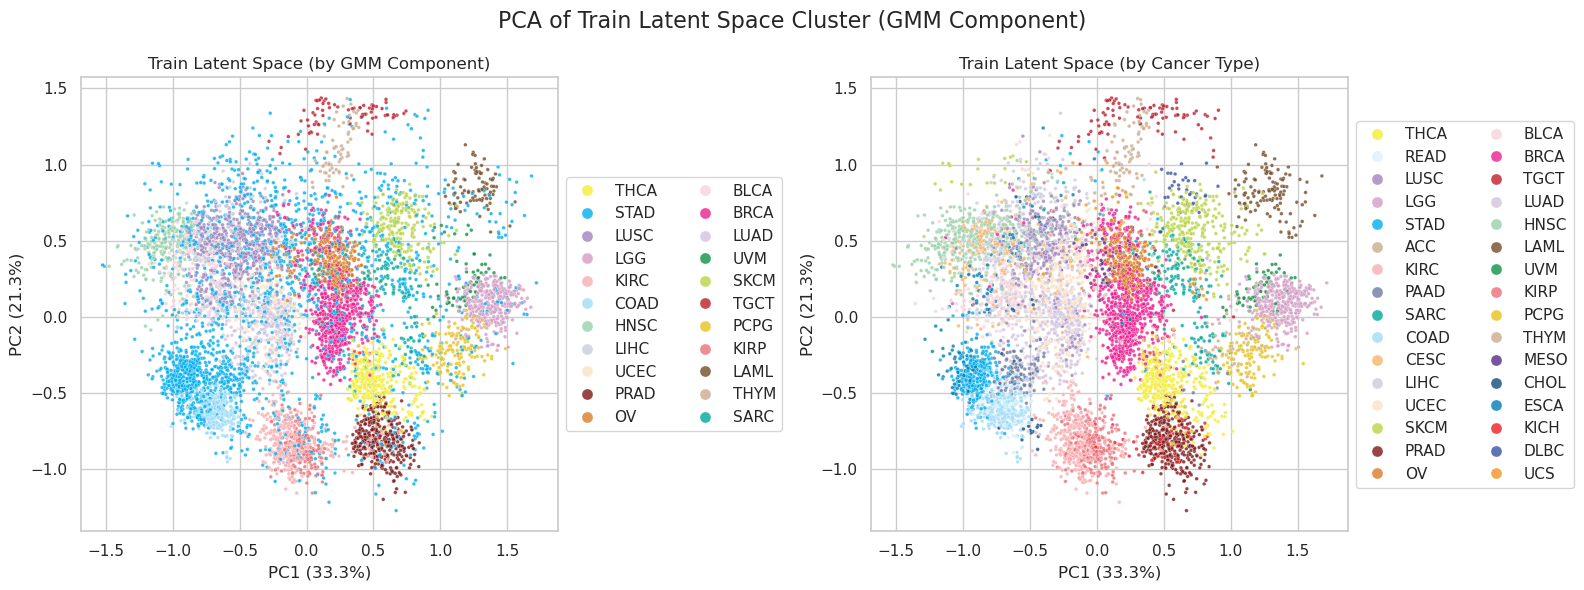

In [99]:
plot_latent_component(dgd, dgd.train_rep, train_loader, dataset="Train")

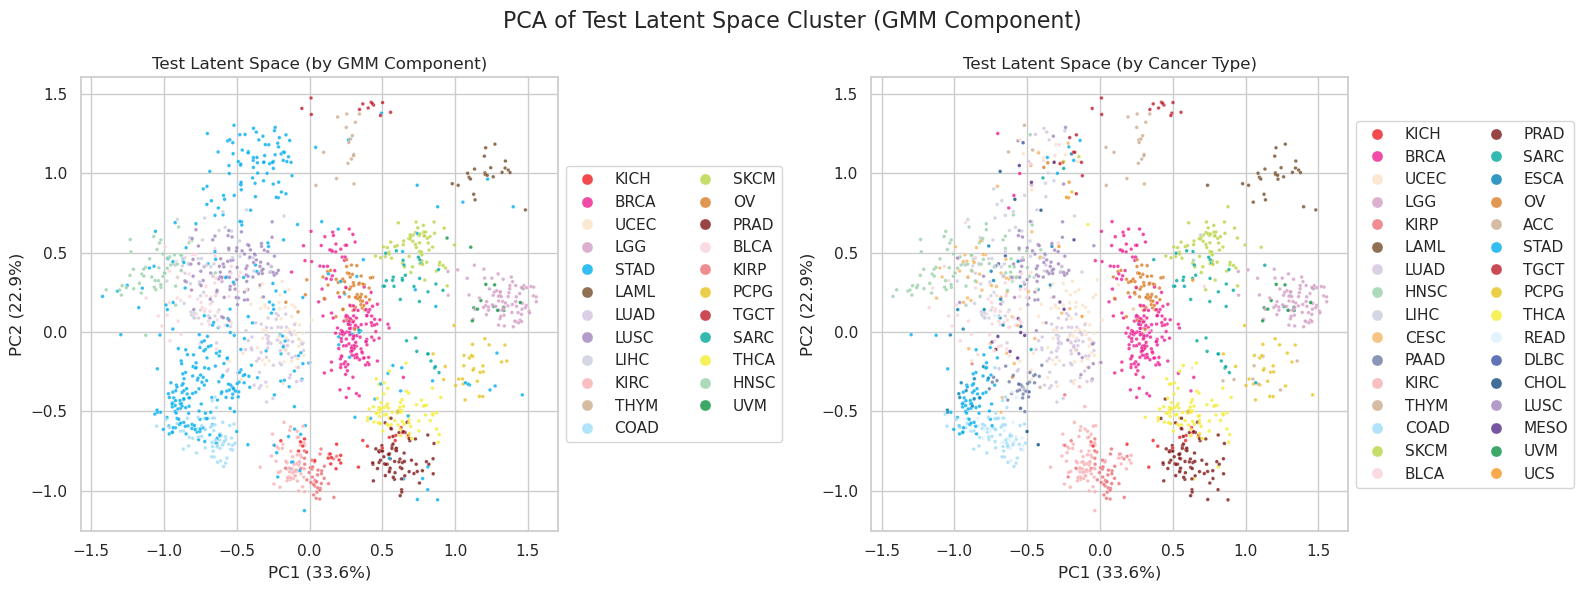

In [100]:
plot_latent_component(dgd, dgd.test_rep, test_loader, dataset="Test")

# Calculate Metrics Measurement

## Rand Index

In [111]:
from sklearn.metrics.cluster import rand_score, adjusted_rand_score

def calculate_rand(dgd_rep, data_loader):
    labels = data_loader.dataset.label
    clustering = []
    
    df = pd.DataFrame(labels, columns=["label"])
    
    rep = dgd_rep
    for i in range(len(rep.z)):
        cluster = dgd.gmm.clustering(rep(i)).unsqueeze(0).detach().cpu().numpy()
        clustering.extend(cluster)
    df["cluster"] = clustering
    df["cluster"] = df["cluster"].astype('category')

    label_counts = df.groupby(['cluster', 'label'], observed=False).size().reset_index(name='counts')
    most_frequent_labels = label_counts.loc[label_counts.groupby('cluster', observed=False)['counts'].idxmax()]
    cluster_to_label = dict(zip(most_frequent_labels['cluster'], most_frequent_labels['label']))
    df['cluster_name'] = df['cluster'].map(cluster_to_label)

    rand_index = adjusted_rand_score(df["label"], df["cluster_name"])

    return rand_index

In [112]:
print(calculate_rand(dgd.train_rep, train_loader))

0.3379472358797847


In [113]:
print(calculate_rand(dgd.test_rep, test_loader))

0.45034009345136955


## Average Spearman Corr

In [320]:
def average_correlation(true, pred, method='pearson'):
    """
    # axis 0 for features, axis 1 for samples
    """
    def avg_corr(true, pred, method, axis):
        if method == 'pearson':
            corr = true.corrwith(pred, axis=axis, method=method)
        elif method == 'spearman':
            corr = true.corrwith(pred, axis=axis, method='spearman')
        else:
            raise ValueError("Method must be 'pearson' or 'spearman'")
        
        avg_corr = corr.mean()
        
        return avg_corr

    avg_corr_features = avg_corr(true, pred, method, axis=0)
    avg_corr_samples = avg_corr(true, pred, method, axis=1)

    return avg_corr_features, avg_corr_samples

In [321]:
# Test
average_correlation(y_test.iloc[:,:-4], X_test.iloc[:,:-4], method='spearman')

(0.3470025207954922, 0.8010006178674486)

In [322]:
# Test
average_correlation(y_train.iloc[:,:-4], X_train.iloc[:,:-4], method='spearman')

(0.4421053243462536, 0.8070607454246413)

In [347]:
sparsity = ["1000", "5000", "1e+4", "5e+4", "1e+5", "5e+5", "1e+6", "5e+6", "1e+7"]
corr_sparsity = []
sp_sparsity = []
for i, sp in enumerate(sparsity):
    X, y = _get_data_pred_from_rep(dgd, test_rep_load[i], test_loader, mirna_column)
    corr = average_correlation(X.iloc[:,:-4], y.iloc[:,:-4], method='spearman')
    corr_sparsity.append(corr)
    sp_sparsity.append(sp)
    
df_corr_sparsity = pd.DataFrame(corr_sparsity, columns=["feature", "sample"])
df_corr_sparsity['sparsity'] = sp_sparsity

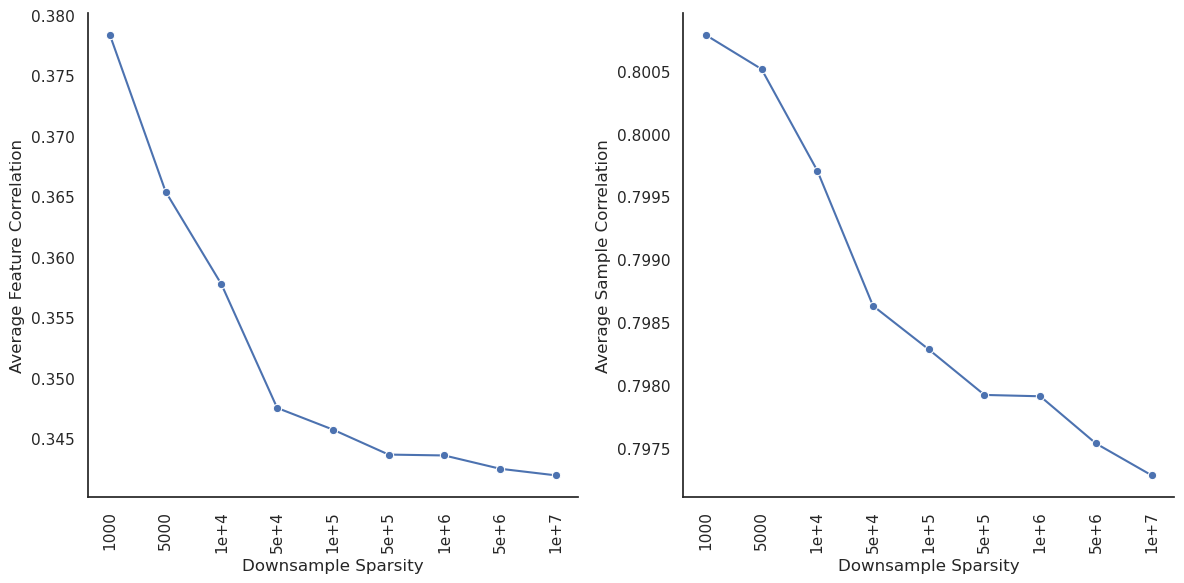

In [384]:
# Set the style
sns.set_style("white")

# Create the plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for feature correlation
sns.lineplot(data=df_corr_sparsity, x='sparsity', y='feature', marker='o', ax=axes[0])
# axes[0].set_title('Average Feature Correlation vs. Sparsity')
axes[0].set_xlabel('Downsample Sparsity')
axes[0].set_ylabel('Average Feature Correlation')
axes[0].tick_params(axis='x', rotation=90)

# Plot for sample correlation
sns.lineplot(data=df_corr_sparsity, x='sparsity', y='sample', marker='o', ax=axes[1])
# axes[1].set_title('Average Sample Correlation vs. Sparsity')
axes[1].set_xlabel('Downsample Sparsity')
axes[1].set_ylabel('Average Sample Correlation')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
sns.despine()
plt.savefig(os.path.join("plots", "Sparse data spearman corr.pdf"))
plt.show()

# Top 50 Pearson Correlation

In [277]:
from scipy import stats

def calculate_corr(X, y):
    spearman_corr = []
    pearson_corr = []
    spearman_pval = []
    pearson_pval = []
    r2 = []
    r2_pval = []
    
    for i in range(y_test.shape[1]-4):
        # Calculate Spearman correlation coefficient
        spearman, spearman_p = stats.spearmanr(X.iloc[:,i], y.iloc[:,i])
        pearson, pearson_p = stats.pearsonr(X.iloc[:,i], y.iloc[:,i])
        _, _, r_value, r_p, _ = stats.linregress(X.iloc[:,i], y.iloc[:,i])
        
        spearman_corr.append(spearman)
        pearson_corr.append(pearson)
        r2.append(r_value**2)
        spearman_pval.append(spearman_p)
        pearson_pval.append(pearson_p)
        r2_pval.append(r_p)
        
    corr_data = pd.DataFrame(
        data={  
            'pearson': pearson_corr,
            'spearman': spearman_corr,
            'r2': r2,
            'pearson_p': pearson_pval,
            'spearman_p': spearman_pval,
            'r2_p': r2_pval,
            'mirna': X.columns[:-4]
        },
        index=np.arange(0, len(X.columns[:-4]))
    )
    return corr_data.sort_values(by='pearson', ascending=False, ignore_index=True)

def calculate_pearson(X, y, sparsity):
    pearson_corr = []
    pearson_pval = []
    
    for i in range(y_test.shape[1]-4):
        # Calculate Spearman correlation coefficient
        pearson, pearson_p = stats.pearsonr(X.iloc[:,i], y.iloc[:,i])
        pearson_corr.append(pearson)
        pearson_pval.append(pearson_p)
        
    corr_data = pd.DataFrame(
        data={  
            'mirna': X.columns[:-4],
            'pearson': pearson_corr,
            'sparsity': np.repeat(sparsity, len(X.columns[:-4]))
        },
        index=np.arange(0, len(X.columns[:-4]))
    )
    return corr_data.sort_values(by='pearson', ascending=False, ignore_index=True)

def calculate_spearman(X, y, sparsity):
    spearman_corr = []
    spearman_pval = []
    
    for i in range(y_test.shape[1]-4):
        # Calculate Spearman correlation coefficient
        spearman, spearman_p = stats.spearmanr(X.iloc[:,i], y.iloc[:,i])
        spearman_corr.append(spearman)
        spearman_pval.append(spearman_p)
        
    corr_data = pd.DataFrame(
        data={  
            'mirna': X.columns[:-4],
            'spearman': spearman_corr,
            'sparsity': np.repeat(sparsity, len(X.columns[:-4]))
        },
        index=np.arange(0, len(X.columns[:-4]))
    )
    return corr_data.sort_values(by='spearman', ascending=False, ignore_index=True)

In [278]:
corr_data_spearman = calculate_spearman(X_test, y_test, "Bulk")
corr_data_pearson = calculate_pearson(X_test, y_test, "Bulk")

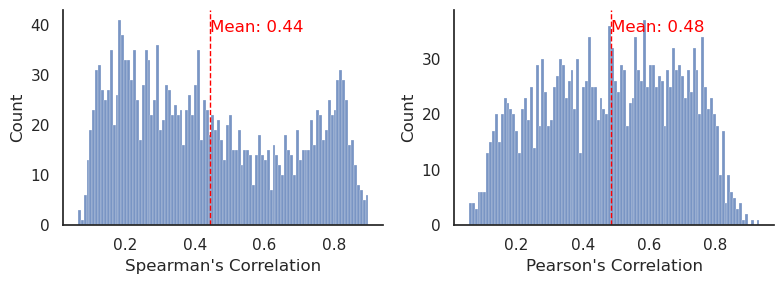

In [391]:
corr_data = calculate_corr(X_train, y_train)

sns.set_style("white")
fig = plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
sns.histplot(data=corr_data, x='spearman', bins=100)
# plt.title("Spearman's Correlation")
plt.xlabel("Spearman's Correlation")
mean_spearman = corr_data['spearman'].mean()
plt.axvline(mean_spearman, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_spearman, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_spearman:.2f}', color='red')

plt.subplot(1,2,2)
sns.histplot(data=corr_data, x='pearson', bins=100)
# plt.title("Pearson's Correlation")
plt.xlabel("Pearson's Correlation")
mean_pearson = corr_data['pearson'].mean()
plt.axvline(mean_pearson, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_pearson, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_pearson:.2f}', color='red')

# Add the main title to the figure
# fig.suptitle("miRNA Correlation Distribution", fontsize=24)

# Display the plots
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join("plots", "corr mirna midgd train.svg"))
plt.show()

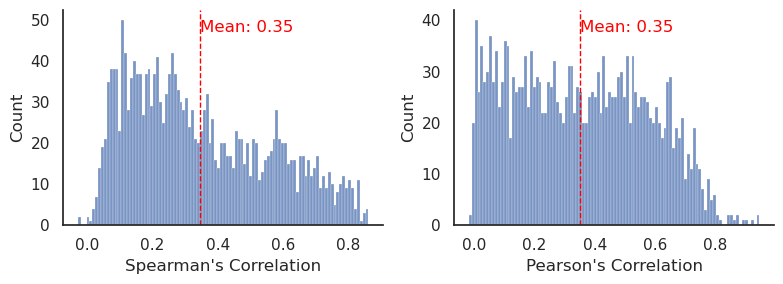

In [392]:
corr_data = calculate_corr(X_test, y_test)

sns.set_style("white")
fig = plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
sns.histplot(data=corr_data, x='spearman', bins=100)
# plt.title("Spearman's Correlation")
plt.xlabel("Spearman's Correlation")
mean_spearman = corr_data['spearman'].mean()
plt.axvline(mean_spearman, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_spearman, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_spearman:.2f}', color='red')

plt.subplot(1,2,2)
sns.histplot(data=corr_data, x='pearson', bins=100)
# plt.title("Pearson's Correlation")
plt.xlabel("Pearson's Correlation")
mean_pearson = corr_data['pearson'].mean()
plt.axvline(mean_pearson, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_pearson, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_pearson:.2f}', color='red')

# Add the main title to the figure
# fig.suptitle("miRNA Correlation Distribution", fontsize=24)

# Display the plots
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join("plots", "corr mirna midgd test.svg"))
plt.show()

In [279]:
top_mirna_spearman = corr_data_spearman.head(50)
top_mirna_pearson = corr_data_pearson.head(50)

In [315]:
sparsity = ["1000", "5000", "10000", "50000", "100000", "500000", "1000000", "5000000", "10000000"]

pearson_mirna = top_mirna_pearson

for i, sp in enumerate(sparsity):
    X, y = _get_data_pred_from_rep(dgd, test_rep_load[i], test_loader, mirna_column)
    corr = calculate_pearson(X, y, sp)
    mask = corr['mirna'].isin(pearson_mirna['mirna'])
    corr_filtered = corr[mask]
    pearson_mirna = pd.concat([pearson_mirna, corr_filtered])

pearson_mirna

mirna   pearson  sparsity
0       hsa-miR-9-3p  0.945090      Bulk
1    hsa-miR-302b-5p  0.939132      Bulk
2    hsa-miR-302d-5p  0.922107      Bulk
3       hsa-miR-9-5p  0.902062      Bulk
4     hsa-miR-122-5p  0.890401      Bulk
..               ...       ...       ...
103   hsa-miR-194-3p  0.678499  10000000
108  hsa-miR-200b-3p  0.674081  10000000
145   hsa-miR-367-5p  0.654453  10000000
238  hsa-miR-5589-5p  0.609477  10000000
253  hsa-miR-548t-5p  0.604673  10000000

[500 rows x 3 columns]

In [316]:
sparsity = ["1000", "5000", "10000", "50000", "100000", "500000", "1000000", "5000000", "10000000"]

spearman_mirna = top_mirna_spearman

for i, sp in enumerate(sparsity):
    X, y = _get_data_pred_from_rep(dgd, test_rep_load[i], test_loader, mirna_column)
    corr = calculate_spearman(X, y, sp)
    mask = corr['mirna'].isin(spearman_mirna['mirna'])
    corr_filtered = corr[mask]
    spearman_mirna = pd.concat([spearman_mirna, corr_filtered])

spearman_mirna

mirna  spearman  sparsity
0    hsa-miR-141-5p  0.861371      Bulk
1    hsa-miR-140-3p  0.859733      Bulk
2   hsa-miR-200b-3p  0.859700      Bulk
3   hsa-miR-200c-3p  0.853475      Bulk
4   hsa-miR-125b-5p  0.850478      Bulk
..              ...       ...       ...
59    hsa-miR-21-3p  0.771212  10000000
62   hsa-miR-218-5p  0.769490  10000000
67   hsa-miR-145-3p  0.762973  10000000
69   hsa-miR-221-3p  0.762475  10000000
75  hsa-miR-203a-3p  0.758909  10000000

[500 rows x 3 columns]

# GMM Component Clustering

In [282]:
def gmm_clustering(dgd, rep):
    # if dataset == "train":
    #     rep = dgd.train_rep
    # elif dataset == "val":
    #     rep = dgd.val_rep
    # elif dataset == "test":
    #     rep = dgd.test_rep
        
    clustering = []
    for i in range(len(rep.z)):
        cluster = dgd.gmm.clustering(rep(i)).unsqueeze(0).detach().cpu().numpy()
        clustering.extend(cluster)
    clustering = np.array(clustering)
    
    return clustering

test_clustering = gmm_clustering(dgd, dgd.test_rep)
train_clustering = gmm_clustering(dgd, dgd.train_rep)

In [283]:
test_clustering

array([16,  6, 13, ..., 19, 21,  4], dtype=int16)

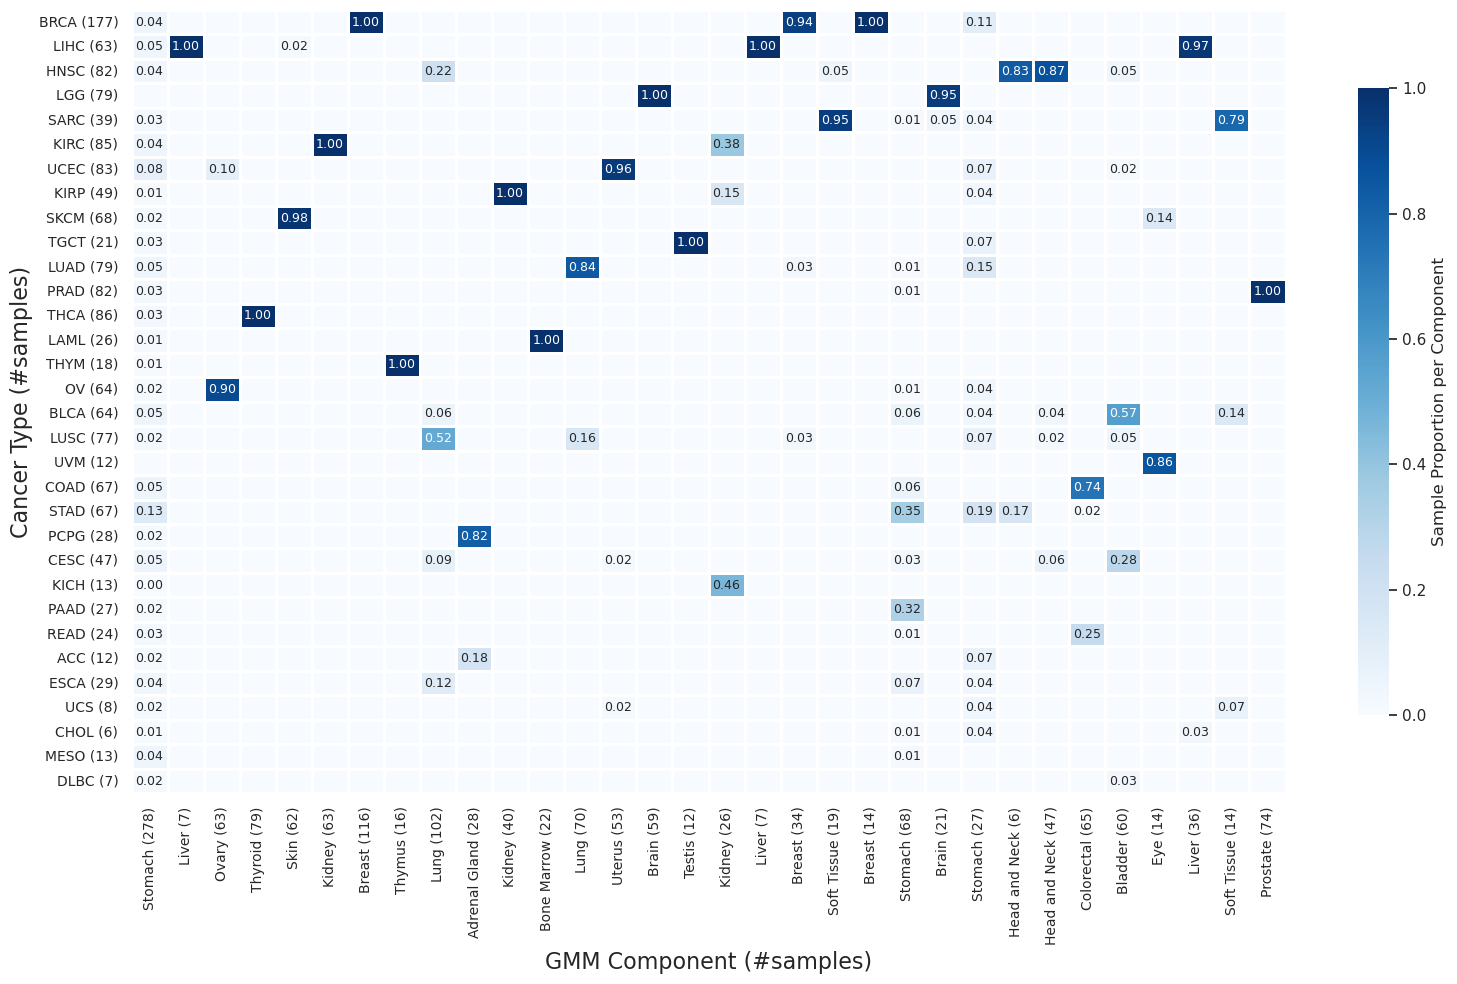

In [292]:
def gmm_clustering_plot(cluster, data_loader, tissue_mapping, is_save=False, savedir="plots", filename=None):
    gmm_comp = pd.DataFrame(
        data={
            'component': cluster,
            'cancer_type': data_loader.dataset.label
        }
    )
    
    # Create dataframe
    df = pd.crosstab(gmm_comp['cancer_type'], gmm_comp['component'])
    df = df.div(df.sum(axis=0))
    df['row_sum'] = df.sum(axis=1)
    df = df.sort_values(by='row_sum', ascending=False)
    df = df.drop(['row_sum'], axis=1)
    
    # Y label
    primary_site_counts = pd.Series(data_loader.dataset.label).value_counts().reset_index()
    primary_site_counts.columns = ['cancer_type', 'count']
    primary_site_counts = primary_site_counts.set_index('cancer_type')
    primary_site_counts = primary_site_counts.loc[df.index]
    primary_site_counts = primary_site_counts.reset_index()
    y_labels = [f"{cancer_type} ({count})" for cancer_type, count in zip(primary_site_counts['cancer_type'], primary_site_counts['count'])]
    
    # X label
    component_counts = pd.Series(cluster).value_counts().sort_index()
    
    # Determine the primary site with the highest count for each component
    primary_site_per_component = df.idxmax(axis=0).map(tissue_mapping)
    x_labels = [f"{primary_site_per_component[component]} ({count})" for component, count in zip(component_counts.index, component_counts.values)]
    
    # Create a heatmap using seaborn
    sns.set_style(style="white")
    plt.subplots(figsize=(16, 10))
    annot = df.map(lambda x: f'{x:.2f}' if x != 0 else '')
    cmap = mpl.colormaps.get_cmap('Blues')
    cmap.set_bad("white")
    g = sns.heatmap(df, annot=annot, mask=False, cmap=cmap, fmt='', linewidth=0.8, annot_kws={'size': 9},
                    cbar_kws={'shrink': 0.8, 'label': 'Sample Proportion per Component'})
    g.set_yticklabels(g.get_yticklabels(), rotation=0)
    plt.xlabel("GMM Component (#samples)", fontsize=16)
    plt.ylabel("Cancer Type (#samples)", fontsize=16)
    g.set_xticklabels(x_labels, fontsize=10, rotation=90)
    g.set_yticklabels(y_labels, fontsize=10)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

gmm_clustering_plot(test_clustering, test_loader, tissue_mapping, filename="GMM Clustering test data.pdf")

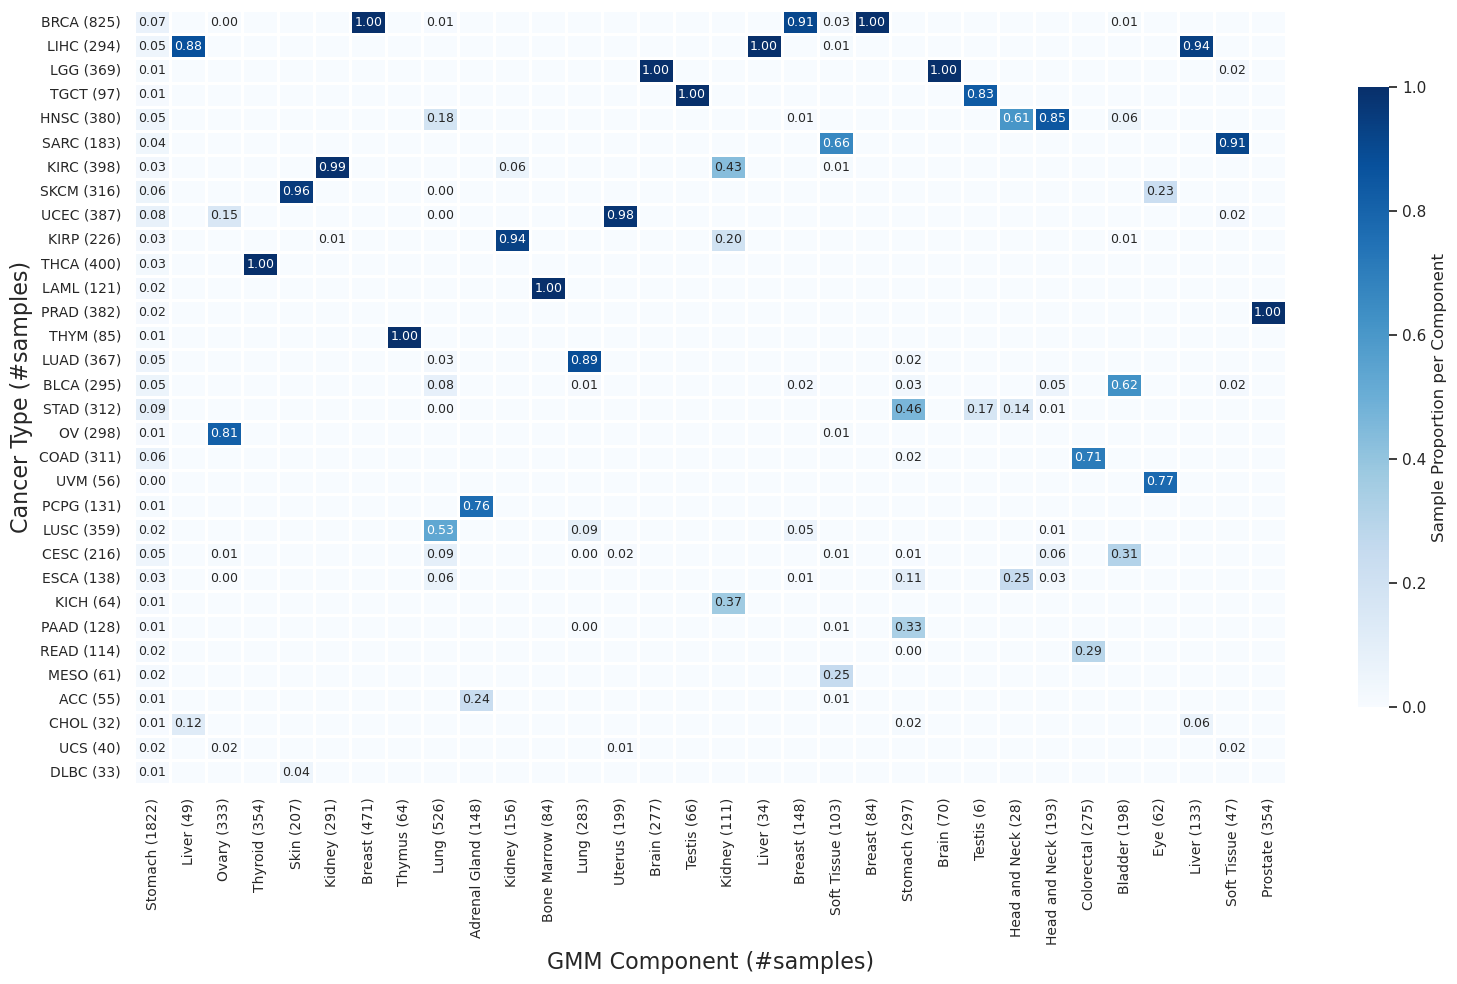

In [293]:
gmm_clustering_plot(train_clustering, train_loader, tissue_mapping, filename="GMM Clustering train data.pdf")

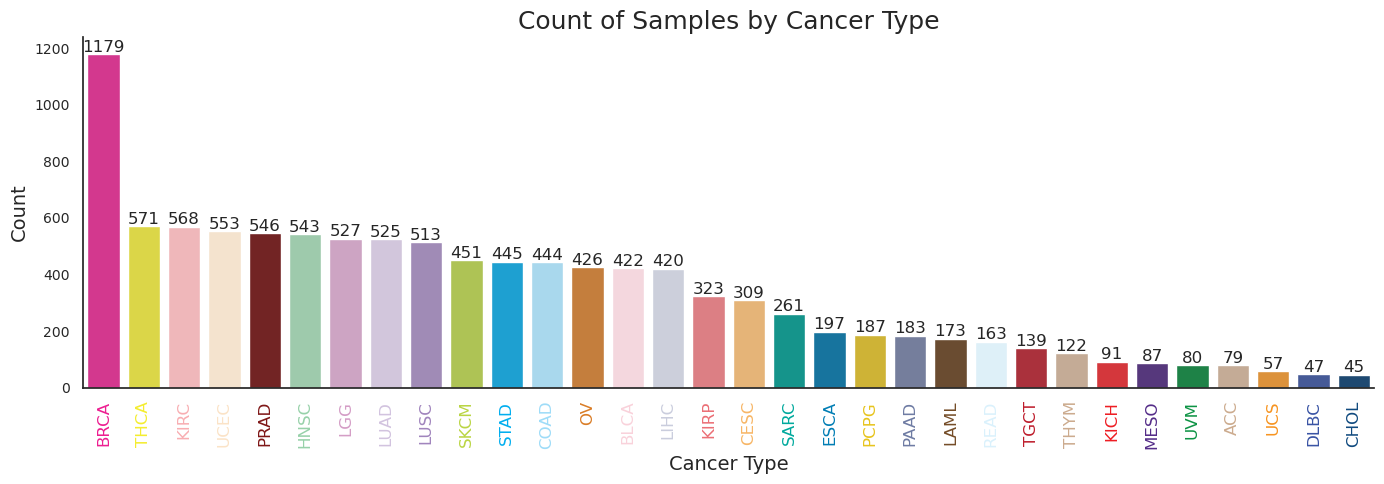

In [172]:
sns.set_style(style="white")
color_mapping = dict(zip(tcga_mrna['cancer_type'], tcga_mrna['color']))

primary_site_counts = tcga_mrna['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(14, 5))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Samples by Cancer Type', fontsize=18)
plt.xticks(rotation=90, fontsize=12)  # Rotate the x labels to show them more clearly
plt.yticks(fontsize=10)

for ax in plt.gcf().axes:
    labels = ax.get_xticklabels()
    for label, cancer_type in zip(labels, primary_site_counts['cancer_type'].unique()):
        label.set_color(palette[cancer_type])

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 5),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
sns.despine()
plt.show()

# Dot Plot Top miRNA

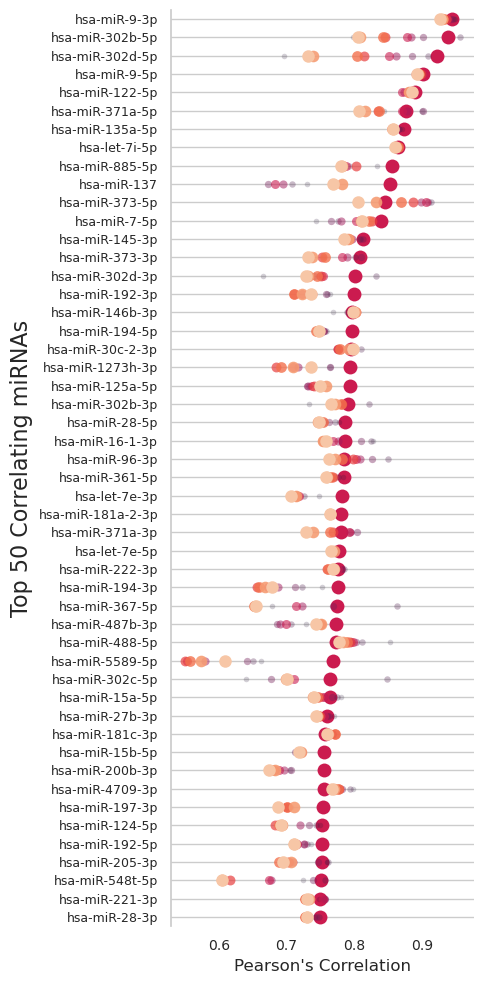

In [317]:
def plot_stripplot_corr_pearson(pearson_mirna, savedir="plots", filename=None):
    # Define the sparsity values
    sparsity = ["1000", "5000", "10000", "50000", "100000", "500000", "1000000", "5000000", "10000000"]
    
    # Set the color palette
    palette = sns.color_palette("rocket", n_colors=len(sparsity))
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(5, 10))
    
    # Plot the "Bulk" sparsity data
    sns.stripplot(x="pearson", y="mirna", hue="sparsity", data=pearson_mirna[pearson_mirna["sparsity"] == "Bulk"],
                  size=10, alpha=1.0, palette="rocket", ax=ax, dodge=True, legend=False)
    
    # Plot the stripplot for other sparsity values
    for i, sp in enumerate(sparsity):
        # Calculate the size and alpha based on the sparsity value
        size = 4 + (i / (len(sparsity) - 1)) * 5  # Increase size from 3 to 10
        alpha = 0.2 + (i / (len(sparsity) - 1)) * 0.8  # Increase alpha from 0.2 to 1.0
        
        # Plot the data for the current sparsity value
        sns.stripplot(x="pearson", y="mirna", hue="sparsity", data=pearson_mirna[pearson_mirna["sparsity"] == sp],
                      size=size, alpha=alpha, palette=[palette[i]], ax=ax, dodge=True, legend=False)
    
    # Add horizontal grid lines
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    
    # Create custom legend handles for sizes
    size_handles = [plt.Line2D([], [], marker='o', color=palette[i], markersize=4 + (i / (len(sparsity) - 1)) * 5, alpha=0.2 + (i / (len(sparsity) - 1)) * 0.8, label=sp) for i, sp in enumerate(sparsity)]
    bulk_handle = plt.Line2D([], [], marker='o', color=palette[4], markersize=10, alpha=1.0, label='Bulk')
    
    # Combine all handles
    all_handles = size_handles + [bulk_handle]
    
    # Add combined legend
    ax.legend(handles=all_handles, title="Sparsity", loc="upper left", bbox_to_anchor=(1.01, 1), ncol=1, fontsize='10').set_visible(False)
    
    # Adjust plot layout
    plt.subplots_adjust(right=0.8)
    sns.despine(bottom=True)
    plt.xlabel("Pearson's Correlation", fontsize=12)
    plt.ylabel("Top 50 Correlating miRNAs", fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

plot_stripplot_corr_pearson(pearson_mirna, filename="Top 50 Pearson Corr.svg")

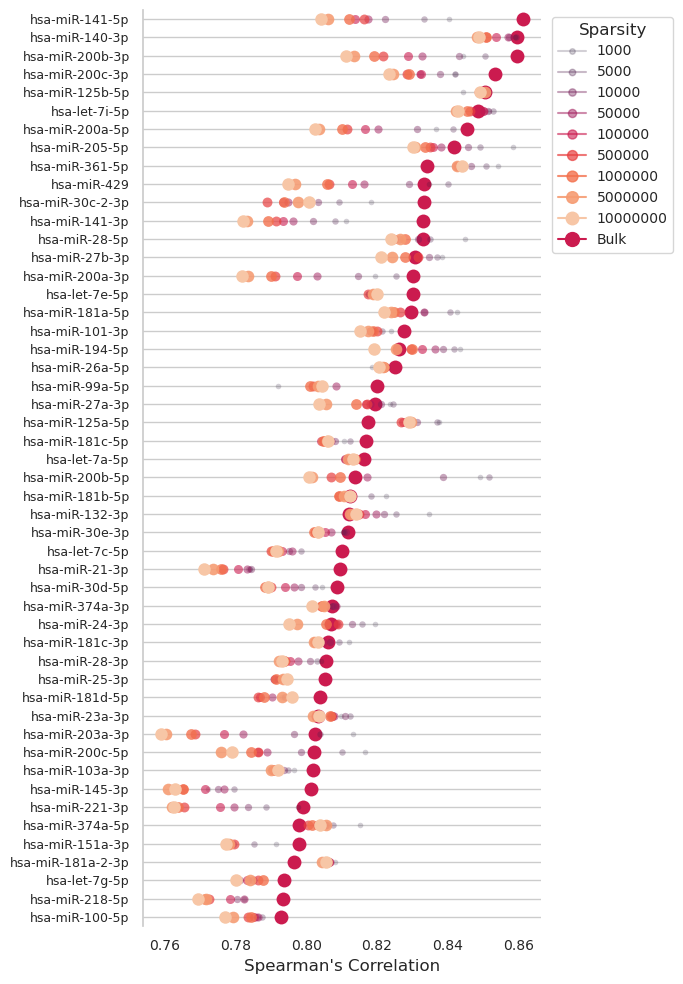

In [318]:
def plot_stripplot_corr_spearman(spearman_mirna, savedir="plots", filename=None):
    # Define the sparsity values
    sparsity = ["1000", "5000", "10000", "50000", "100000", "500000", "1000000", "5000000", "10000000"]
    
    # Set the color palette
    palette = sns.color_palette("rocket", n_colors=len(sparsity))
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(7, 10))
    
    # Plot the "Bulk" sparsity data
    sns.stripplot(x="spearman", y="mirna", hue="sparsity", data=spearman_mirna[spearman_mirna["sparsity"] == "Bulk"],
                  size=10, alpha=1.0, palette="rocket", ax=ax, dodge=True, legend=False)
    
    # Plot the stripplot for other sparsity values
    for i, sp in enumerate(sparsity):
        # Calculate the size and alpha based on the sparsity value
        size = 4 + (i / (len(sparsity) - 1)) * 5  # Increase size from 3 to 10
        alpha = 0.2 + (i / (len(sparsity) - 1)) * 0.8  # Increase alpha from 0.2 to 1.0
        
        # Plot the data for the current sparsity value
        sns.stripplot(x="spearman", y="mirna", hue="sparsity", data=spearman_mirna[spearman_mirna["sparsity"] == sp],
                      size=size, alpha=alpha, palette=[palette[i]], ax=ax, dodge=True, legend=False)
    
    # Add horizontal grid lines
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    
    # Create custom legend handles for sizes
    size_handles = [plt.Line2D([], [], marker='o', color=palette[i], markersize=4 + (i / (len(sparsity) - 1)) * 5, alpha=0.2 + (i / (len(sparsity) - 1)) * 0.8, label=sp) for i, sp in enumerate(sparsity)]
    bulk_handle = plt.Line2D([], [], marker='o', color=palette[4], markersize=10, alpha=1.0, label='Bulk')
    
    # Combine all handles
    all_handles = size_handles + [bulk_handle]
    
    # Add combined legend
    ax.legend(handles=all_handles, title="Sparsity", loc="upper left", bbox_to_anchor=(1.01, 1), ncol=1, fontsize='10')
    
    # Adjust plot layout
    plt.subplots_adjust(right=0.8)
    sns.despine(bottom=True)
    plt.xlabel("Spearman's Correlation", fontsize=12)
    plt.ylabel("Top 50 Correlating miRNAs", fontsize=16).set_visible(False)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

plot_stripplot_corr_spearman(spearman_mirna, filename="Top 50 Spearman Corr.svg")

In [ ]:
top_pearson = []
top_spearman = ['hsa-miR']

# True vs predicted miRNA grouped by cancer type

In [306]:
def plot_jitter_grouped_cancer(subset):
    data = get_mirna_data(dgd, data_loader, subset=subset)
    
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    plt.subplot(2, 1, 1)
    sns.boxplot(data=data, x="cancer_type", y="y", hue="cancer_type", palette=palette, boxprops=dict(alpha=.5), showfliers=False)
    sns.stripplot(data=data, x="cancer_type", y="y", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
    plt.title("")
    plt.xlabel("")
    plt.ylabel("True expression", fontsize=11)
    plt.xticks([], [])
    
    plt.subplot(2, 1, 2)
    sns.boxplot(data=data, x="cancer_type", y="X", hue="cancer_type", palette=palette, boxprops=dict(alpha=.5), showfliers=False)
    sns.stripplot(data=data, x="cancer_type", y="X", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
    plt.title("")
    plt.xlabel("Cancer Type", fontsize=14)
    plt.ylabel("Predicted expression", fontsize=11)
    plt.xticks(rotation=90, fontsize=12)

    for ax in plt.gcf().axes:
        labels = ax.get_xticklabels()
        for label, cancer_type in zip(labels, data['cancer_type'].unique()):
            label.set_color(palette[cancer_type])
    
    plt.suptitle(f"{subset} expression", fontsize=18)
    sns.despine(bottom=True)
    plt.tight_layout()
    plt.show()


def plot_jitter_grouped_tissue(subset, savedir="plots", filename=None):
    data = get_mirna_data(dgd, data_loader, subset=subset)
    
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    plt.subplot(2, 1, 1)
    sns.boxplot(data=data, x="cancer_type", y="y", hue="tissue", boxprops=dict(alpha=.3), showfliers=False)
    sns.stripplot(data=data, x="cancer_type", y="y", hue="tissue", alpha=0.8, zorder=0, palette="Paired")
    plt.title("")
    plt.xlabel("")
    plt.ylabel("True expression", fontsize=12)
    plt.xticks([], [])
    plt.yticks(fontsize=9)
    plt.legend(fontsize=8)
    
    plt.subplot(2, 1, 2)
    sns.boxplot(data=data, x="cancer_type", y="X", hue="tissue", boxprops=dict(alpha=.3), showfliers=False)
    sns.stripplot(data=data, x="cancer_type", y="X", hue="tissue", alpha=0.8, zorder=0, palette="Paired")
    plt.title("")
    plt.xlabel("Cancer Type", fontsize=14)
    plt.ylabel("Predicted expression", fontsize=12)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=9)
    plt.legend(fontsize=8).remove()

    for ax in plt.gcf().axes:
        labels = ax.get_xticklabels()
        for label, cancer_type in zip(labels, data['cancer_type'].unique()):
            label.set_color(palette[cancer_type])
    plt.suptitle(f"{subset} expression", fontsize=18)
    sns.despine(bottom=True)
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

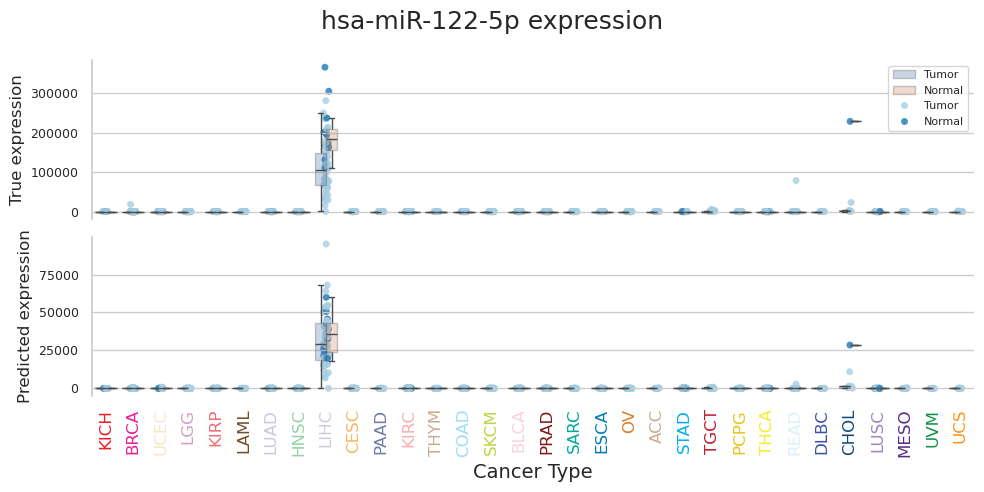

In [307]:
plot_jitter_grouped_tissue('hsa-miR-122-5p', filename="Group jitter hsa-miR-122-5p.pdf")

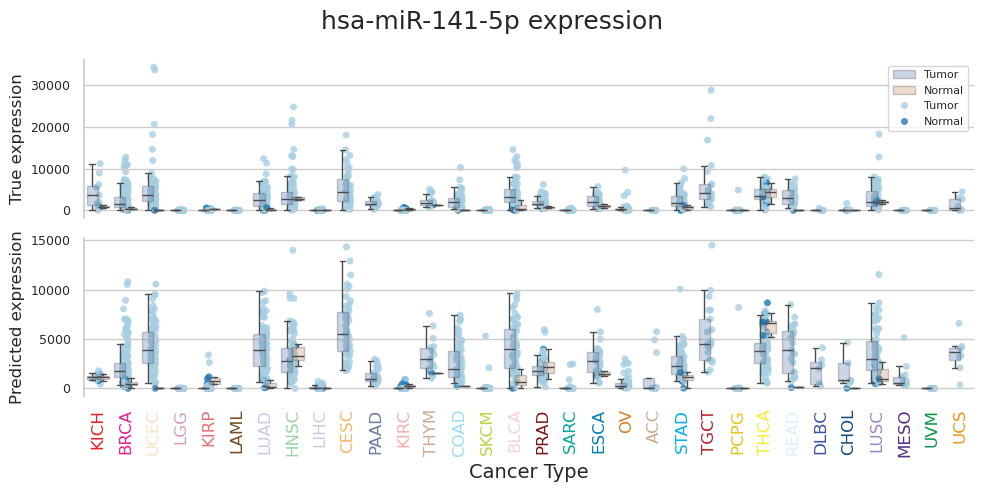

In [310]:
plot_jitter_grouped_tissue('hsa-miR-141-5p')

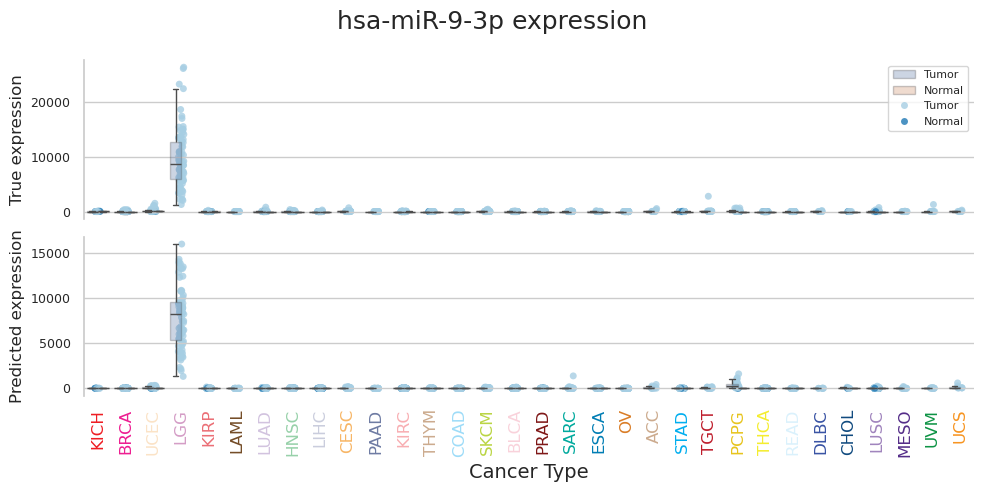

In [309]:
plot_jitter_grouped_tissue('hsa-miR-9-3p', filename="Group jitter hsa-miR-9-3p.pdf")

# Regression Plot

In [53]:
def regression_plot(subset, cancer_type=None, savedir="plots", filename=None):
    test = get_mirna_data(dgd, data_loader, subset=subset, dataset="test")

    if cancer_type:
        test = test[test['cancer_type'] == cancer_type]
    
    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")
    
    # Create a figure to hold the subplots
    plt.figure(figsize=(5, 5))
    # plt.subplots_adjust(hspace=1)
    
    # Create scatterplot
    sns.regplot(data=test, x="X", y="y", scatter_kws={"s": 5, "alpha": .9}, line_kws={"color": "red", "alpha": .5})
    sns.despine()
    # Calculate Spearman correlation coefficient
    spearman_corr, spearman_p = stats.spearmanr(test['X'], test['y'])
    pearson_corr, pearson_p = stats.pearsonr(test['X'], test['y'])
    # Add correlation coefficient as text annotation
    plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}, p-value = <2.2e-16", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}, p-value = <2.2e-16", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.xlabel("Predicted expression", fontsize=12)
    plt.ylabel("True expression", fontsize=12)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    if cancer_type:
        plt.title(f"{subset} expression in {cancer_type} samples", fontsize=16, y=1.05)
    else:
        plt.title(f"{subset} expression", fontsize=16, y=1.05)
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

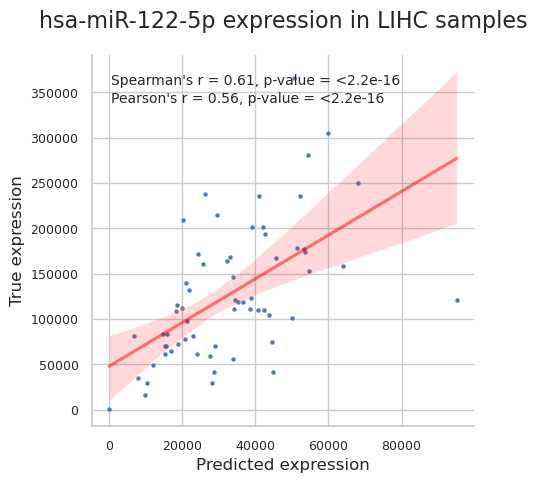

In [54]:
regression_plot('hsa-miR-122-5p', 'LIHC', filename="Regplot hsa-miR-122-5p.pdf")

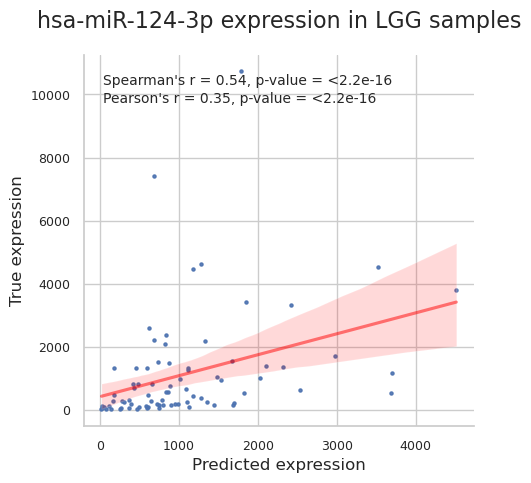

In [55]:
regression_plot('hsa-miR-124-3p', 'LGG', filename="Regplot hsa-miR-124-3p.pdf")

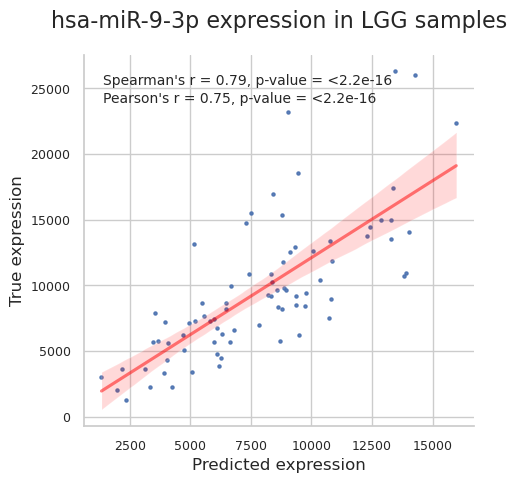

In [100]:
regression_plot('hsa-miR-9-3p', 'LGG', filename="Regplot hsa-miR-9-3p.pdf")

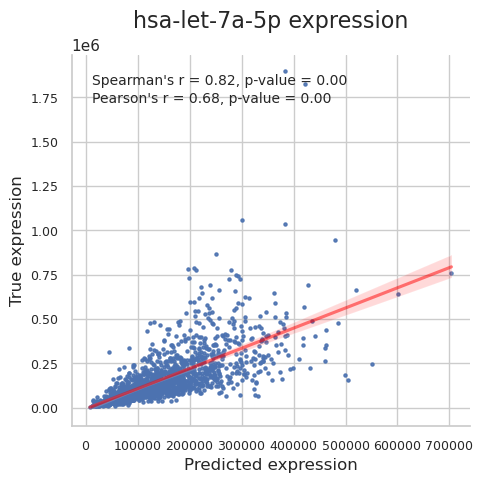

In [889]:
regression_plot('hsa-let-7a-5p')

# Regression Plot on Different Sparsity

In [152]:
def regression_plot(subset, data_loader, savedir="plots", filename=None):
    test = get_mirna_data(dgd, data_loader, subset=subset, dataset="test")
    
    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")
    
    # Create a figure to hold the subplots
    plt.figure(figsize=(5, 5))
    # plt.subplots_adjust(hspace=1)
    
    # Create scatterplot
    sns.regplot(data=test, x="X", y="y", scatter_kws={"s": 5, "alpha": .9}, line_kws={"color": "red", "alpha": .5})
    sns.despine()
    # Calculate Spearman correlation coefficient
    spearman_corr, spearman_p = stats.spearmanr(test['X'], test['y'])
    pearson_corr, pearson_p = stats.pearsonr(test['X'], test['y'])
    # Add correlation coefficient as text annotation
    plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}, p-value = {spearman_p:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}, p-value = {pearson_p:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.xlabel("Predicted expression", fontsize=12)
    plt.ylabel("True expression", fontsize=12)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.title(f"{subset} expression", fontsize=16, y=1.05)
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

In [175]:
test_loaders[8].dataset.mirna_data

tensor([[1.8448e+05, 2.8000e+01, 7.3342e+04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.1611e+05, 2.8000e+02, 3.3062e+05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.2106e+05, 1.1000e+01, 8.7773e+04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [5.1871e+05, 7.0100e+02, 1.8030e+05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.7137e+05, 3.4000e+01, 1.3016e+05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.9255e+05, 4.1000e+01, 9.9352e+04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

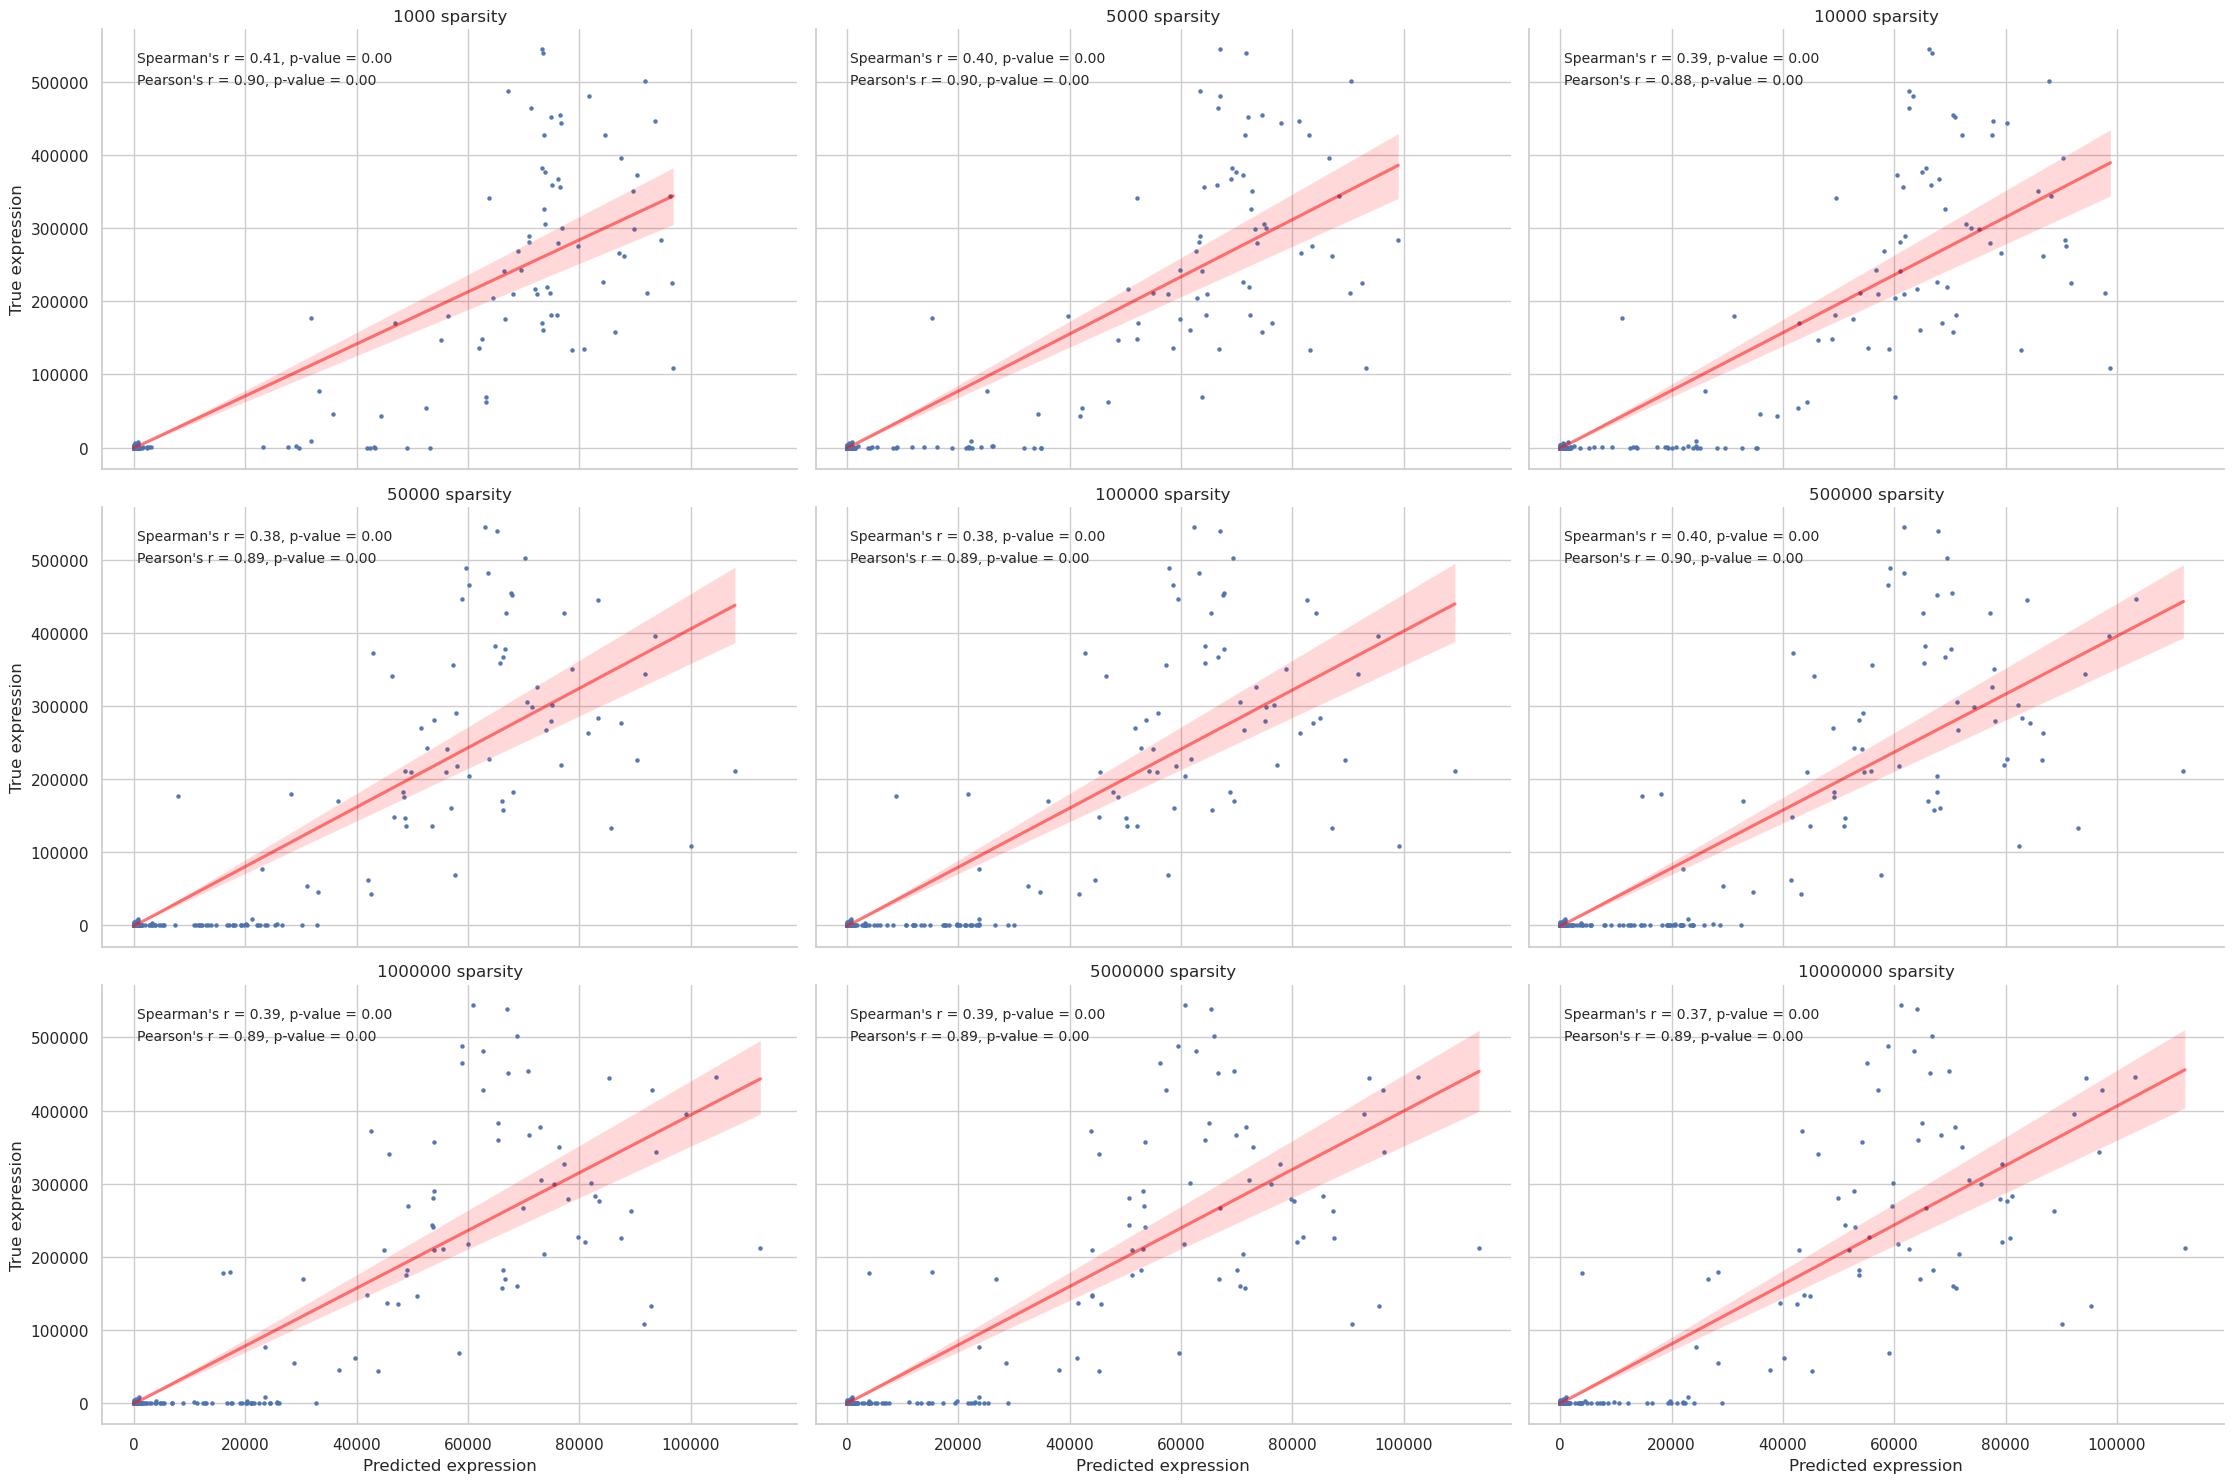

In [178]:
sparsity = ["1000", "5000", "10000", "50000", "100000", "500000", "1000000", "5000000", "10000000"]

def regplot_sparsity(dgd, test_rep_load, test_loaders, mirna_column, subset, savedir="plots", filename=None):
    # Create an empty DataFrame to hold all data
    all_data = pd.DataFrame()
    
    for i, sp in enumerate(sparsity):
        X, y = _get_data_pred_from_rep(dgd, test_rep_load[i], test_loaders[i], mirna_column)
        df = pd.DataFrame(
                    data={
                        'X': X.loc[:,subset], 
                        'y': y.loc[:,subset],
                        'cancer_type': X.loc[:,'cancer_type'],
                        'tissue': X.loc[:,'tissue'],
                        'color': X.loc[:,'color'],
                        'sparsity': sp  # Add sparsity as a column
                    }
                )
        all_data = pd.concat([all_data, df], ignore_index=True)
    
    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")
    
    # Create a FacetGrid
    g = sns.FacetGrid(all_data, col="sparsity", col_wrap=3, height=5, aspect=1.5)
    g.map_dataframe(sns.regplot, x="X", y="y", scatter_kws={"s": 5, "alpha": .9}, line_kws={"color": "red", "alpha": .5})
    
    # Add correlation coefficients to each facet
    for ax, (name, group) in zip(g.axes.flat, all_data.groupby("sparsity")):
        spearman_corr, spearman_p = stats.spearmanr(group['X'], group['y'])
        pearson_corr, pearson_p = stats.pearsonr(group['X'], group['y'])
        ax.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}, p-value = {spearman_p:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')
        ax.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}, p-value = {pearson_p:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')
    
    g.set_axis_labels("Predicted expression", "True expression")
    g.set_titles(col_template="{col_name} sparsity")
    
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

# Example usage
regplot_sparsity(dgd, test_rep_load, test_loaders, mirna_column, 'hsa-miR-122-5p', filename="regplot_facet.png")

# Joint Plot

In [547]:
def joint_plot(subset):
    data = get_mirna_data(dgd, data_loader, subset=subset)
    
    g = sns.JointGrid(data=data, x="X", y="y", hue='tissue', height=6, ratio=6,
                     xlim=(0, 10000), ylim=(0, 10000))
    g.plot_joint(sns.scatterplot, s=20)
    g.plot_marginals(sns.rugplot, height=.5)
    g.set_axis_labels("Predicted exp", "True exp")
    plt.tight_layout()
    plt.show()

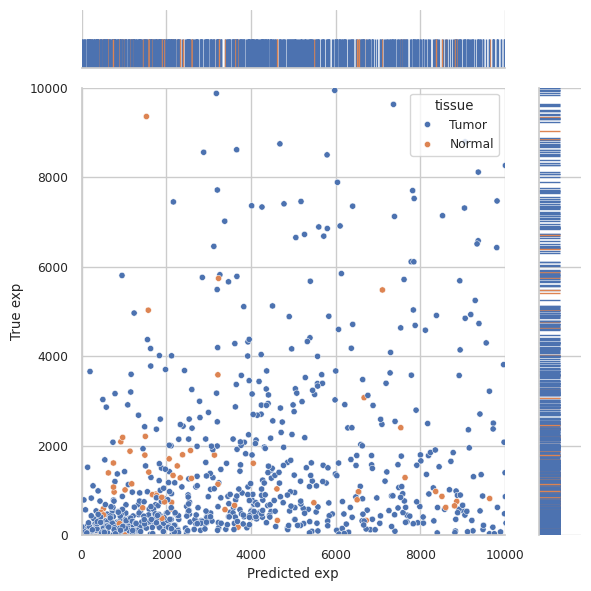

In [548]:
joint_plot('hsa-miR-9-5p')

# Training loss

In [364]:
mrna_loss = torch.load('results/final_loss_mrna.pickle')
mirna_loss = torch.load('results/final_loss_mirna.pickle')

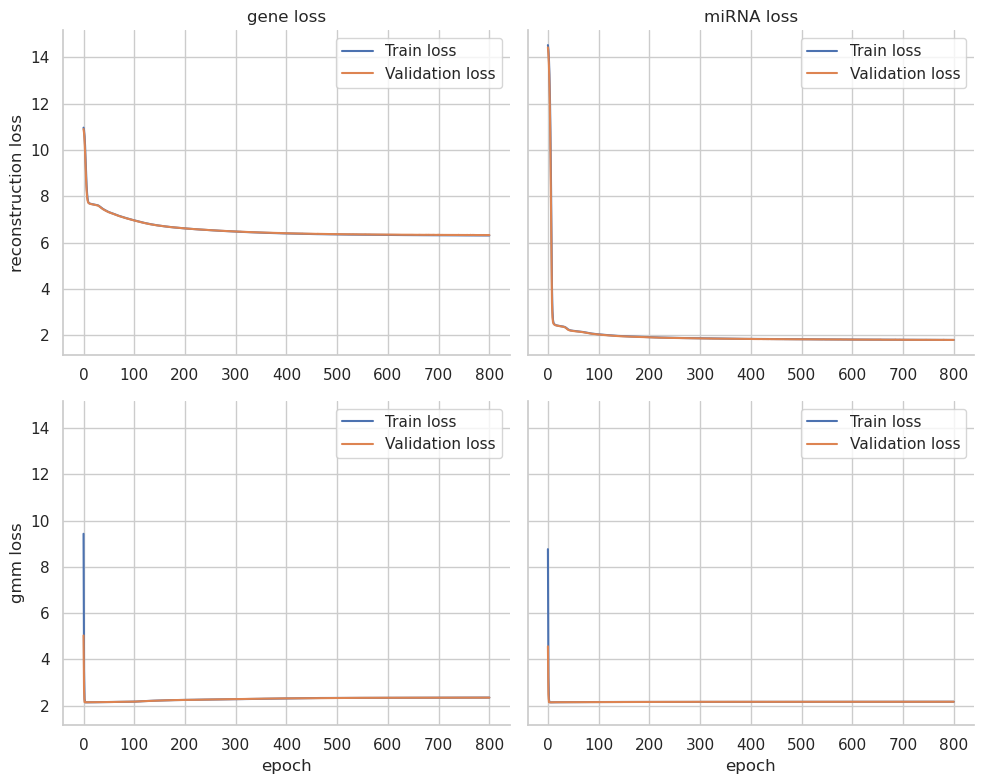

In [395]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots with shared y-axis
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss (mRNA)
sns.lineplot(ax=axes[0, 0], x="epoch", y="train_recon", data=mrna_loss, label="Train loss")
sns.lineplot(ax=axes[0, 0], x="epoch", y="test_recon", data=mrna_loss, label="Validation loss")
axes[0, 0].set_title("gene loss")
axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("reconstruction loss")

# Second subplot for Reconstruction loss (miRNA)
sns.lineplot(ax=axes[0, 1], x="epoch", y="train_recon", data=mirna_loss, label="Train loss")
sns.lineplot(ax=axes[0, 1], x="epoch", y="test_recon", data=mirna_loss, label="Validation loss")
axes[0, 1].set_title("miRNA loss")
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("reconstruction loss")
axes[0, 1].set_ylabel("")

# Third subplot for GMM loss (mRNA)
sns.lineplot(ax=axes[1, 0], x="epoch", y="train_gmm", data=mrna_loss, label="Train loss")
sns.lineplot(ax=axes[1, 0], x="epoch", y="test_gmm", data=mrna_loss, label="Validation loss")
axes[1, 0].set_title("")
axes[1, 0].set_xlabel("epoch")
axes[1, 0].set_ylabel("gmm loss")

# Fourth subplot for GMM loss (miRNA)
sns.lineplot(ax=axes[1, 1], x="epoch", y="train_gmm", data=mirna_loss, label="Train loss")
sns.lineplot(ax=axes[1, 1], x="epoch", y="test_gmm", data=mirna_loss, label="Validation loss")
axes[1, 1].set_title("")
axes[1, 1].set_xlabel("epoch")
axes[1, 1].set_ylabel("")
axes[1, 1].set_ylabel("")

# Display the plots
plt.tight_layout()
sns.despine()
plt.savefig(os.path.join("plots", "Training loss metrics single.pdf"))
plt.show()

In [376]:
sample_annot.head(3)

sample_id cancer_type sample_submitter_id  \
1  TCGA-EW-A6SA-01A-21R-A32P-07        BRCA    TCGA-EW-A6SA-01A   
2  TCGA-E2-A14W-01A-11R-A12D-07        BRCA    TCGA-E2-A14W-01A   
3  TCGA-EW-A1PD-01A-11R-A144-07        BRCA    TCGA-EW-A1PD-01A   

                 cancer_name primary_site    sample_type  \
1  Breast Invasive Carcinoma       Breast  Primary Tumor   
2  Breast Invasive Carcinoma       Breast  Primary Tumor   
3  Breast Invasive Carcinoma       Breast  Primary Tumor   

                               id_match tissue_type tumor_descriptor  \
1  e19e25fc-d85f-4caa-a22d-d48a461a735d       Tumor          Primary   
2  4a010aac-f287-4fa7-9d3b-8af64c5d23e4       Tumor          Primary   
3  010de2d6-ab41-4779-923a-1c288296e267       Tumor          Primary   

  age_at_index gender vital_status tissue_or_organ_of_origin    color  
1           59   male        Alive               Breast, NOS  #ED1E91  
2           78   male        Alive               Breast, NOS  #ED1E91  
3           61   male        Alive               Breast, NOS  #ED1E91